In [ ]:
import os
import json
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import sys
sys.path.append("src")

from exploretinyrm.trm import TRM, TRMConfig, RMSNorm
from tsp_data_gen import write_dataset, pairwise_euclidean, tour_length


In [3]:
def set_seed(seed: int = 123) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# Fixed maximum number of cities for padding (TRM seq_len must be constant)
MAX_CITIES = 12

# Dataset path
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
DATA_PATH = str(DATA_DIR / "tsp_moves_mixed.jsonl")

GENERATE_DATASET_IF_MISSING = True

# Dataset generation settings (match generator)
NUM_PROBLEMS = 2500
N_MIN = 6
N_MAX = MAX_CITIES
SEED_DATA = 1234

P_CONSTRUCTIVE = 0.7
INSERT_STEPS_PER_PROBLEM = 6
TWO_OPT_STEPS_PER_PROBLEM = 6
STEP_SAMPLING = "mid"          # "uniform" | "early" | "mid" | "late" | "all"
NOISE_MIN = 2
NOISE_MAX = 4
INCLUDE_STOP_PROB = 0.20

# Training
BATCH_SIZE = 128 if device.type == "cuda" else 64
NUM_WORKERS = 0
USE_AMP = (device.type == "cuda")

# TRM backbone size
D_MODEL = 192
N_HEADS = 6                    # must divide D_MODEL
N_LAYERS = 2

# TRM recursion settings
INNER_Z_UPDATES = 6            # cfg.n
DEEP_RECURSIONS = 3            # cfg.T
K_LAST_OPS = None              # truncate last ops inside final recursion  

# Outer iterative refinement steps ("N_SUP" idea from paper)
OUTER_STEPS = 6                # number of supervised outer steps per example

# Optim
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.0
GRAD_CLIP_NORM = 1.0

# Epochs
EPOCHS_INSERT = 15
EPOCHS_TWO_OPT = 15


In [5]:
if (not os.path.exists(DATA_PATH)) and GENERATE_DATASET_IF_MISSING:
    print("Generating dataset:", DATA_PATH)
    write_dataset(
        out_path=DATA_PATH,
        num_problems=NUM_PROBLEMS,
        n_min=N_MIN,
        n_max=N_MAX,
        seed=SEED_DATA,
        p_constructive=P_CONSTRUCTIVE,
        ins_per=INSERT_STEPS_PER_PROBLEM,
        opt_per=TWO_OPT_STEPS_PER_PROBLEM,
        step_sample=STEP_SAMPLING,
        noise_min=NOISE_MIN,
        noise_max=NOISE_MAX,
        include_stop_prob=INCLUDE_STOP_PROB,
    )
    print("Wrote:", DATA_PATH)
else:
    print("Using existing dataset:", DATA_PATH)


Using existing dataset: data/tsp_moves_mixed.jsonl


In [6]:
def load_jsonl_split_with_costs(path: str) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    insert_items: List[Dict[str, Any]] = []
    two_opt_items: List[Dict[str, Any]] = []

    with open(path, "r") as file_handle:
        for line in file_handle:
            example = json.loads(line)

            coords = np.array(example["coords"], dtype=np.float32)
            n_nodes = int(coords.shape[0])

            if example["mode"] == "insert":
                tour_partial = np.array(example["tour_partial"], dtype=np.int64)
                m = int(tour_partial.shape[0])

                # JSON stores "position" in 1..m (insert at that position), we convert to edge index 0..m-1
                pos_raw = int(example["action"]["position"])
                target_edge_index = (pos_raw - 1) % m

                insert_items.append({
                    "coords": coords,                          # [n,2]
                    "n_nodes": n_nodes,
                    "tour_partial": tour_partial,              # [m]
                    "partial_length": m,
                    "target_city": int(example["action"]["city"]),
                    "target_edge_index": int(target_edge_index),
                    "cost_before": float(example.get("cost_before", np.nan)),
                    "cost_after": float(example.get("cost_after", np.nan)),
                })

            elif example["mode"] == "two_opt":
                tour_full = np.array(example["tour_full"], dtype=np.int64)
                action = example["action"]
                stop = bool(action.get("stop", False))
                target_i = -1 if stop else int(action["i"])
                target_j = -1 if stop else int(action["j"])

                two_opt_items.append({
                    "coords": coords,                         # [n,2]
                    "n_nodes": n_nodes,
                    "tour_full": tour_full,                   # [n]
                    "stop": stop,
                    "target_i": target_i,
                    "target_j": target_j,
                    "cost_before": float(example.get("cost_before", np.nan)),
                    "cost_after": float(example.get("cost_after", np.nan)),
                })

    return insert_items, two_opt_items


insert_items, two_opt_items = load_jsonl_split_with_costs(DATA_PATH)
print("Loaded items:")
print("  insert:", len(insert_items))
print("  two_opt:", len(two_opt_items))


Loaded items:
  insert: 3020
  two_opt: 3209


In [ ]:
def split_list(items: List[Any], val_fraction: float = 0.1, seed: int = 0) -> Tuple[List[Any], List[Any]]:
    rng = np.random.RandomState(seed)
    indices = np.arange(len(items))
    rng.shuffle(indices)
    cut = int((1.0 - val_fraction) * len(items))
    train_indices = indices[:cut].tolist()
    val_indices = indices[cut:].tolist()
    train_items = [items[i] for i in train_indices]
    val_items = [items[i] for i in val_indices]
    return train_items, val_items


class InsertDataset(Dataset):
    def __init__(self, items: List[Dict[str, Any]]):
        self.items = items

    def __len__(self) -> int:
        return len(self.items)

    def __getitem__(self, index: int) -> Dict[str, Any]:
        return self.items[index]


class TwoOptDataset(Dataset):
    def __init__(self, items: List[Dict[str, Any]]):
        self.items = items

    def __len__(self) -> int:
        return len(self.items)

    def __getitem__(self, index: int) -> Dict[str, Any]:
        return self.items[index]


def collate_insert_fixed(batch: List[Dict[str, Any]], max_cities: int) -> Dict[str, torch.Tensor]:
    batch_size = len(batch)

    coords = torch.zeros(batch_size, max_cities, 2, dtype=torch.float32)
    node_valid_mask = torch.zeros(batch_size, max_cities, dtype=torch.bool)

    visited_mask = torch.zeros(batch_size, max_cities, dtype=torch.float32)
    tour_partial = torch.full((batch_size, max_cities), -1, dtype=torch.long)
    partial_length = torch.zeros(batch_size, dtype=torch.long)

    target_city = torch.zeros(batch_size, dtype=torch.long)
    target_edge_index = torch.zeros(batch_size, dtype=torch.long)

    cost_before = torch.full((batch_size,), float("nan"), dtype=torch.float32)
    cost_after = torch.full((batch_size,), float("nan"), dtype=torch.float32)

    for batch_index, item in enumerate(batch):
        n_nodes = int(item["n_nodes"])
        m = int(item["partial_length"])
        assert n_nodes <= max_cities, "Increase MAX_CITIES or restrict data."

        coords[batch_index, :n_nodes] = torch.from_numpy(item["coords"])
        node_valid_mask[batch_index, :n_nodes] = True

        tour_partial[batch_index, :m] = torch.from_numpy(item["tour_partial"])
        partial_length[batch_index] = m

        # visited from partial tour
        for v in item["tour_partial"]:
            visited_mask[batch_index, int(v)] = 1.0

        target_city[batch_index] = int(item["target_city"])
        target_edge_index[batch_index] = int(item["target_edge_index"])

        cost_before[batch_index] = float(item["cost_before"])
        cost_after[batch_index] = float(item["cost_after"])

    return {
        "coords": coords,
        "node_valid_mask": node_valid_mask,
        "visited_mask": visited_mask,
        "tour_partial": tour_partial,
        "partial_length": partial_length,
        "target_city": target_city,
        "target_edge_index": target_edge_index,
        "cost_before": cost_before,
        "cost_after": cost_after,
    }


def enumerate_two_opt_pairs(tour: List[int]) -> List[Tuple[int, int]]:
    n = len(tour)
    pairs: List[Tuple[int, int]] = []
    for i in range(1, n - 2):
        a, b = tour[i - 1], tour[i]
        for j in range(i + 1, n - 1):
            c, d = tour[j], tour[(j + 1) % n]
            if b == c or a == d:
                continue
            pairs.append((i, j))
    return pairs


def collate_two_opt_fixed(batch: List[Dict[str, Any]], max_cities: int) -> Dict[str, Any]:
    batch_size = len(batch)

    coords = torch.zeros(batch_size, max_cities, 2, dtype=torch.float32)
    node_valid_mask = torch.zeros(batch_size, max_cities, dtype=torch.bool)
    tour_full = torch.full((batch_size, max_cities), -1, dtype=torch.long)

    n_nodes_tensor = torch.zeros(batch_size, dtype=torch.long)

    candidate_lists: List[List[Tuple[int, int]]] = []
    target_pair_index_list: List[int] = []

    cost_before = torch.full((batch_size,), float("nan"), dtype=torch.float32)
    cost_after = torch.full((batch_size,), float("nan"), dtype=torch.float32)

    for batch_index, item in enumerate(batch):
        n_nodes = int(item["n_nodes"])
        assert n_nodes <= max_cities, "Increase MAX_CITIES or restrict data."

        coords[batch_index, :n_nodes] = torch.from_numpy(item["coords"])
        node_valid_mask[batch_index, :n_nodes] = True
        n_nodes_tensor[batch_index] = n_nodes

        tour = item["tour_full"].tolist()
        tour_full[batch_index, :n_nodes] = torch.from_numpy(item["tour_full"])

        pairs = enumerate_two_opt_pairs(tour)
        candidate_lists.append(pairs)

        if item["stop"]:
            # STOP is at index len(pairs)
            target_pair_index_list.append(len(pairs))
        else:
            pair_to_index = {p: idx for idx, p in enumerate(pairs)}
            target_pair_index_list.append(pair_to_index[(int(item["target_i"]), int(item["target_j"]))])

        cost_before[batch_index] = float(item["cost_before"])
        cost_after[batch_index] = float(item["cost_after"])

    # Pad candidate pairs to the maximum in the batch (+1 STOP)
    max_pairs_plus_stop = max(len(pairs) + 1 for pairs in candidate_lists)
    pair_indices = torch.full((batch_size, max_pairs_plus_stop, 2), -1, dtype=torch.long)
    pair_mask = torch.zeros(batch_size, max_pairs_plus_stop, dtype=torch.bool)

    for batch_index, pairs in enumerate(candidate_lists):
        k = len(pairs)
        if k > 0:
            pair_indices[batch_index, :k] = torch.tensor(pairs, dtype=torch.long)
        pair_mask[batch_index, :k + 1] = True  # pairs + STOP slot

    target_pair_index = torch.tensor(target_pair_index_list, dtype=torch.long)

    return {
        "coords": coords,
        "node_valid_mask": node_valid_mask,
        "tour_full": tour_full,
        "n_nodes": n_nodes_tensor,
        "pair_indices": pair_indices,
        "pair_mask": pair_mask,
        "target_pair_index": target_pair_index,
        "cost_before": cost_before,
        "cost_after": cost_after,
    }


# Build loaders
insert_train, insert_val = split_list(insert_items, val_fraction=0.1, seed=0)
two_opt_train, two_opt_val = split_list(two_opt_items, val_fraction=0.1, seed=1)

insert_train_loader = DataLoader(
    InsertDataset(insert_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
    collate_fn=lambda batch: collate_insert_fixed(batch, MAX_CITIES),
)

insert_val_loader = DataLoader(
    InsertDataset(insert_val),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
    collate_fn=lambda batch: collate_insert_fixed(batch, MAX_CITIES),
)





BATCH_SIZE_TWO_OPT = 32

two_opt_train_loader = DataLoader(
    TwoOptDataset(two_opt_train),
    batch_size=BATCH_SIZE_TWO_OPT,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
    collate_fn=lambda batch: collate_two_opt_fixed(batch, MAX_CITIES),
)

two_opt_val_loader = DataLoader(
    TwoOptDataset(two_opt_val),
    batch_size=BATCH_SIZE_TWO_OPT,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
    collate_fn=lambda batch: collate_two_opt_fixed(batch, MAX_CITIES),
)

print("Two-opt loaders rebuilt with batch size:", BATCH_SIZE_TWO_OPT)

if device.type == "cuda":
    torch.cuda.empty_cache()




print("Loader sizes:")
print("  insert train:", len(insert_train_loader), "val:", len(insert_val_loader))
print("  two-opt train:", len(two_opt_train_loader), "val:", len(two_opt_val_loader))


Two-opt loaders rebuilt with batch size: 32
Loader sizes:
  insert train: 22 val: 3
  two-opt train: 91 val: 11


In [8]:
insert_batch = next(iter(insert_train_loader))
two_opt_batch = next(iter(two_opt_train_loader))

print("Insert batch keys:", list(insert_batch.keys()))
for key, value in insert_batch.items():
    if torch.is_tensor(value):
        print(" ", key, tuple(value.shape), value.dtype)

print("\nTwo-opt batch keys:", list(two_opt_batch.keys()))
for key, value in two_opt_batch.items():
    if torch.is_tensor(value):
        print(" ", key, tuple(value.shape), value.dtype)

# Assertions
assert insert_batch["coords"].shape[1] == MAX_CITIES
assert two_opt_batch["coords"].shape[1] == MAX_CITIES
assert (insert_batch["target_city"] >= 0).all()
assert (insert_batch["target_city"] < MAX_CITIES).all()
print("\nSanity checks passed.")


Insert batch keys: ['coords', 'node_valid_mask', 'visited_mask', 'tour_partial', 'partial_length', 'target_city', 'target_edge_index', 'cost_before', 'cost_after']
  coords (128, 12, 2) torch.float32
  node_valid_mask (128, 12) torch.bool
  visited_mask (128, 12) torch.float32
  tour_partial (128, 12) torch.int64
  partial_length (128,) torch.int64
  target_city (128,) torch.int64
  target_edge_index (128,) torch.int64
  cost_before (128,) torch.float32
  cost_after (128,) torch.float32

Two-opt batch keys: ['coords', 'node_valid_mask', 'tour_full', 'n_nodes', 'pair_indices', 'pair_mask', 'target_pair_index', 'cost_before', 'cost_after']
  coords (32, 12, 2) torch.float32
  node_valid_mask (32, 12) torch.bool
  tour_full (32, 12) torch.int64
  n_nodes (32,) torch.int64
  pair_indices (32, 46, 2) torch.int64
  pair_mask (32, 46) torch.bool
  target_pair_index (32,) torch.int64
  cost_before (32,) torch.float32
  cost_after (32,) torch.float32

Sanity checks passed.


In [9]:
try:
    from torch.amp import autocast as amp_autocast, GradScaler as AmpGradScaler
    AMP_STYLE_NEW = True
except ImportError:
    from torch.cuda.amp import autocast as amp_autocast, GradScaler as AmpGradScaler
    AMP_STYLE_NEW = False


def make_grad_scaler(is_cuda: bool) -> AmpGradScaler:
    if AMP_STYLE_NEW:
        try:
            return AmpGradScaler("cuda", enabled=is_cuda)
        except TypeError:
            return AmpGradScaler(enabled=is_cuda)
    return AmpGradScaler(enabled=is_cuda)


def autocast_context(is_cuda: bool, use_amp: bool):
    if AMP_STYLE_NEW:
        try:
            return amp_autocast(device_type="cuda", enabled=(is_cuda and use_amp))
        except TypeError:
            return amp_autocast(enabled=(is_cuda and use_amp))
    return amp_autocast(enabled=(is_cuda and use_amp))


grad_scaler = make_grad_scaler(device.type == "cuda")


In [10]:
def normalize_coords(coords: torch.Tensor, node_valid_mask: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    coords: [batch_size, max_cities, 2]
    node_valid_mask: [batch_size, max_cities] bool
    Returns normalized coords (translation + scale normalized) with pads zeroed.
    """
    mask = node_valid_mask.float().unsqueeze(-1)  # [B, N, 1]
    count = mask.sum(dim=1, keepdim=True).clamp(min=1.0)

    mean = (coords * mask).sum(dim=1, keepdim=True) / count
    centered = (coords - mean) * mask

    var = (centered * centered).sum(dim=1, keepdim=True) / count
    std = torch.sqrt(var + eps)
    normalized = centered / std
    return normalized * mask


def apply_insert_action(tour_partial: List[int], city: int, edge_index: int) -> List[int]:
    """
    edge_index in 0..m-1 refers to edge (tour[edge_index] -> tour[(edge_index+1)%m]).
    Insert city between them, which corresponds to list insertion at position edge_index+1.
    """
    m = len(tour_partial)
    insert_position = (edge_index + 1) % m
    return tour_partial[:insert_position] + [city] + tour_partial[insert_position:]


def apply_two_opt_action(tour: List[int], i: int, j: int) -> List[int]:
    return tour[:i] + list(reversed(tour[i:j+1])) + tour[j+1:]


def tour_cost(coords: np.ndarray, tour: List[int]) -> float:
    dist = pairwise_euclidean(coords)
    return float(tour_length(dist, tour))


In [ ]:
class NodeEncoder(nn.Module):
    """
    Builds x_h for TRM from:
      - normalized coordinates (continuous)
      - visited flag (0/1)
      - tour position per city (0..MAX_CITIES-1) plus special indices
    """
    def __init__(self, d_model: int, max_cities: int):
        super().__init__()
        self.d_model = d_model
        self.max_cities = max_cities

        self.coord_proj = nn.Linear(2, d_model, bias=False)

        self.visited_embed = nn.Embedding(2, d_model)
        # position indices:
        #   0 to max_cities-1 actual positions
        #   max_cities = NOT_IN_TOUR
        #   max_cities+1 = PAD
        self.NOT_IN_TOUR_INDEX = max_cities
        self.PAD_INDEX = max_cities + 1
        self.position_embed = nn.Embedding(max_cities + 2, d_model)

        self.norm = RMSNorm(d_model)

    def forward(
        self,
        coords: torch.Tensor,               # [B, N, 2]
        node_valid_mask: torch.Tensor,      # [B, N] bool
        visited_mask: torch.Tensor,         # [B, N] float 0/1
        city_position_index: torch.Tensor,  # [B, N] long in {0 max-1, NOT_IN_TOUR, PAD}
    ) -> torch.Tensor:
        coords_norm = normalize_coords(coords, node_valid_mask)        # [B,N,2]
        coord_features = self.coord_proj(coords_norm)                  # [B,N,D]

        visited_index = visited_mask.long().clamp(min=0, max=1)
        visited_features = self.visited_embed(visited_index)           # [B,N,D]

        position_features = self.position_embed(city_position_index)   # [B,N,D]

        x_h = coord_features + visited_features + position_features
        x_h = self.norm(x_h)
        return x_h


class TRMBackbone(nn.Module):
    """
    Owns a TRM instance but we do not use its token embedding or output heads
    We call its latent_recursion in a TRM-style deep recursion loop
    """
    def __init__(
        self,
        max_cities: int,
        d_model: int,
        n_layers: int,
        n_heads: int,
        inner_z_updates: int,
        deep_recursions: int,
        k_last_ops: int | None,
    ):
        super().__init__()
        cfg = TRMConfig(
            input_vocab_size=1,
            output_vocab_size=1,
            seq_len=max_cities,
            d_model=d_model,
            n_layers=n_layers,
            use_attention=True,
            n_heads=n_heads,
            dropout=0.0,
            mlp_ratio=4.0,
            token_mlp_ratio=2.0,
            n=inner_z_updates,
            T=deep_recursions,
            k_last_ops=k_last_ops,
            stabilize_input_sums=True,
            use_pointer_output=False,
            use_order_assignment=False,
        )
        self.trm = TRM(cfg)

    def init_state(self, batch_size: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.trm.init_state(batch_size=batch_size, device=device)

    def one_outer_step(
        self,
        x_h: torch.Tensor,
        y_state: torch.Tensor,
        z_state: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Do:
          (T-1) deep recursion passes without grad
          1 deep recursion pass with grad
        Return:
          y_grad, z_grad (with grad),
          y_next, z_next (detached for next outer step)
        """
        n = self.trm.cfg.n
        T = self.trm.cfg.T
        k_last_ops = self.trm.cfg.k_last_ops

        # improve state cheaply
        for _ in range(max(0, T - 1)):
            with torch.no_grad():
                y_state, z_state = self.trm.latent_recursion(
                    x_h=x_h, y=y_state, z=z_state,
                    n=n, k_last_ops=None, track_grads=False
                )

        # final recursion with grad
        y_grad, z_grad = self.trm.latent_recursion(
            x_h=x_h, y=y_state, z=z_state,
            n=n, k_last_ops=k_last_ops, track_grads=True
        )

        y_next = y_grad.detach()
        z_next = z_grad.detach()
        return y_grad, z_grad, y_next, z_next





from contextlib import nullcontext
import torch
import torch.nn as nn
import torch.nn.functional as F

# Autocast-off context manager
try:
    from torch.amp import autocast as torch_autocast
    def autocast_disabled(device: torch.device):
        if device.type == "cuda":
            return torch_autocast(device_type="cuda", enabled=False)
        return nullcontext()
except Exception:
    from torch.cuda.amp import autocast as cuda_autocast
    def autocast_disabled(device: torch.device):
        if device.type == "cuda":
            return cuda_autocast(enabled=False)
        return nullcontext()


class InsertPolicyV4(nn.Module):
    """
    Fixes:
      - normalize y before edge features (prevents huge edge logits and million-scale CE)
      - allow outer_grad_steps: only last K outer steps build graphs
    """
    def __init__(self, max_cities: int, d_model: int, backbone: TRMBackbone):
        super().__init__()
        self.max_cities = max_cities
        self.d_model = d_model
        self.backbone = backbone

        self.encoder = NodeEncoder(d_model=d_model, max_cities=max_cities)

        # One shared node norm for all heads (stable scale)
        self.node_norm = RMSNorm(d_model)

        # City head
        self.city_score = nn.Linear(d_model, 1, bias=False)

        # Edge head
        self.edge_mlp = nn.Sequential(
            nn.Linear(4 * d_model, d_model, bias=False),
            nn.GELU(),
            nn.Linear(d_model, 1, bias=False),
        )

    def build_city_positions_from_partial_tour(
        self,
        tour_partial: torch.Tensor,      # [B, N] with -1 pad
        partial_length: torch.Tensor,    # [B]
        node_valid_mask: torch.Tensor,   # [B, N]
    ) -> torch.Tensor:
        B, N = tour_partial.shape
        not_in_tour = self.encoder.NOT_IN_TOUR_INDEX
        pad_index = self.encoder.PAD_INDEX
        city_position = torch.full((B, N), not_in_tour, dtype=torch.long, device=tour_partial.device)

        for b in range(B):
            m = int(partial_length[b].item())
            for pos in range(m):
                city = int(tour_partial[b, pos].item())
                city_position[b, city] = pos

        city_position = city_position.masked_fill(~node_valid_mask, pad_index)
        return city_position

    def build_edge_endpoints(
        self,
        tour_partial: torch.Tensor,     # [B, N]
        partial_length: torch.Tensor,   # [B]
    ):
        B, N = tour_partial.shape
        edge_u = torch.zeros(B, N, dtype=torch.long, device=tour_partial.device)
        edge_v = torch.zeros(B, N, dtype=torch.long, device=tour_partial.device)
        edge_valid_mask = torch.zeros(B, N, dtype=torch.bool, device=tour_partial.device)

        for b in range(B):
            m = int(partial_length[b].item())
            if m <= 0:
                continue
            for k in range(m):
                u = int(tour_partial[b, k].item())
                v = int(tour_partial[b, (k + 1) % m].item())
                edge_u[b, k] = u
                edge_v[b, k] = v
                edge_valid_mask[b, k] = True

        return edge_u, edge_v, edge_valid_mask

    @torch.no_grad()
    def _outer_step_no_grad(self, x_h, y_state, z_state):
        n = self.backbone.trm.cfg.n
        T = self.backbone.trm.cfg.T
        for _ in range(T):
            y_state, z_state = self.backbone.trm.latent_recursion(
                x_h=x_h, y=y_state, z=z_state,
                n=n, k_last_ops=None, track_grads=False
            )
        return y_state, z_state

    def forward_with_losses(
        self,
        batch,
        outer_steps: int,
        step_weighting: str = "linear",
        outer_grad_steps: int | None = None,
        loss_city_weight: float = 1.0,
        loss_edge_weight: float = 1.0,
    ):
        coords = batch["coords"].to(device)
        node_valid_mask = batch["node_valid_mask"].to(device)
        visited_mask = batch["visited_mask"].to(device)
        tour_partial = batch["tour_partial"].to(device)
        partial_length = batch["partial_length"].to(device)

        target_city = batch["target_city"].to(device)
        target_edge_index = batch["target_edge_index"].to(device)

        city_position = self.build_city_positions_from_partial_tour(tour_partial, partial_length, node_valid_mask)
        x_h = self.encoder(coords, node_valid_mask, visited_mask, city_position)

        B = coords.shape[0]
        y_state, z_state = self.backbone.init_state(batch_size=B, device=coords.device)

        available_city_mask = (node_valid_mask & (visited_mask < 0.5))
        edge_u, edge_v, edge_valid_mask = self.build_edge_endpoints(tour_partial, partial_length)

        if outer_grad_steps is None:
            outer_grad_steps = outer_steps
        outer_grad_steps = int(max(1, min(outer_steps, outer_grad_steps)))
        pre_steps = outer_steps - outer_grad_steps

        # Pre-refine state without grad
        for _ in range(pre_steps):
            y_state, z_state = self._outer_step_no_grad(x_h, y_state, z_state)

        total_loss = 0.0
        loss_city_sum = 0.0
        loss_edge_sum = 0.0

        for local_step in range(outer_grad_steps):
            global_step = pre_steps + local_step

            y_grad, z_grad, y_state, z_state = self.backbone.one_outer_step(x_h, y_state, z_state)

            # Head logits in fp32 + normalized y
            with autocast_disabled(y_grad.device):
                y32 = y_grad.float()
                yN = self.node_norm(y32)  # crucial: stabilize magnitude

                big_neg = -1e4

                city_logits = self.city_score(yN).squeeze(-1)           # [B,N]
                city_logits = city_logits.masked_fill(~available_city_mask, big_neg)

                D = yN.shape[-1]
                u = edge_u.clamp(min=0)
                v = edge_v.clamp(min=0)
                y_u = yN.gather(1, u.unsqueeze(-1).expand(-1, -1, D))
                y_v = yN.gather(1, v.unsqueeze(-1).expand(-1, -1, D))

                edge_features = torch.cat([y_u, y_v, (y_u - y_v), (y_u * y_v)], dim=-1)  # [B,N,4D]
                edge_logits = self.edge_mlp(edge_features).squeeze(-1)                   # [B,N]
                edge_logits = edge_logits.masked_fill(~edge_valid_mask, big_neg)

                loss_city = F.cross_entropy(city_logits, target_city)
                loss_edge = F.cross_entropy(edge_logits, target_edge_index)

            if step_weighting == "linear":
                weight = float(global_step + 1) / float(outer_steps)
            elif step_weighting == "last_only":
                weight = 1.0 if (global_step == outer_steps - 1) else 0.0
            else:
                weight = 1.0

            total_loss = total_loss + weight * (loss_city_weight * loss_city + loss_edge_weight * loss_edge)
            loss_city_sum += float(loss_city.detach().item())
            loss_edge_sum += float(loss_edge.detach().item())

        metrics = {
            "loss_city": loss_city_sum / max(1, outer_grad_steps),
            "loss_edge": loss_edge_sum / max(1, outer_grad_steps),
        }
        return total_loss, metrics

    @torch.no_grad()
    def predict(self, batch, outer_steps: int):
        self.eval()
        coords = batch["coords"].to(device)
        node_valid_mask = batch["node_valid_mask"].to(device)
        visited_mask = batch["visited_mask"].to(device)
        tour_partial = batch["tour_partial"].to(device)
        partial_length = batch["partial_length"].to(device)

        city_position = self.build_city_positions_from_partial_tour(tour_partial, partial_length, node_valid_mask)
        x_h = self.encoder(coords, node_valid_mask, visited_mask, city_position)

        B = coords.shape[0]
        y_state, z_state = self.backbone.init_state(batch_size=B, device=coords.device)

        available_city_mask = (node_valid_mask & (visited_mask < 0.5))
        edge_u, edge_v, edge_valid_mask = self.build_edge_endpoints(tour_partial, partial_length)

        last_city_logits = None
        last_edge_logits = None

        for _ in range(outer_steps):
            y_state, z_state = self._outer_step_no_grad(x_h, y_state, z_state)

            with autocast_disabled(y_state.device):
                y32 = y_state.float()
                yN = self.node_norm(y32)
                big_neg = -1e4

                city_logits = self.city_score(yN).squeeze(-1)
                city_logits = city_logits.masked_fill(~available_city_mask, big_neg)

                D = yN.shape[-1]
                u = edge_u.clamp(min=0)
                v = edge_v.clamp(min=0)
                y_u = yN.gather(1, u.unsqueeze(-1).expand(-1, -1, D))
                y_v = yN.gather(1, v.unsqueeze(-1).expand(-1, -1, D))
                edge_features = torch.cat([y_u, y_v, (y_u - y_v), (y_u * y_v)], dim=-1)
                edge_logits = self.edge_mlp(edge_features).squeeze(-1)
                edge_logits = edge_logits.masked_fill(~edge_valid_mask, big_neg)

            last_city_logits = city_logits
            last_edge_logits = edge_logits

        return last_city_logits.argmax(dim=1), last_edge_logits.argmax(dim=1)


class TwoOptPolicyV4(nn.Module):
    """
    Fixes:
      - normalize y before pair features (prevents huge pair logits and 700+ CE)
      - outer_grad_steps to avoid OOM (train only last K outer steps)
    """
    def __init__(self, max_cities: int, d_model: int, backbone: TRMBackbone):
        super().__init__()
        self.max_cities = max_cities
        self.d_model = d_model
        self.backbone = backbone

        self.encoder = NodeEncoder(d_model=d_model, max_cities=max_cities)

        self.node_norm = RMSNorm(d_model)

        self.stop_norm = RMSNorm(d_model)
        self.stop_score = nn.Linear(d_model, 1, bias=False)

        self.pair_mlp = nn.Sequential(
            nn.Linear(4 * d_model, 2 * d_model, bias=False),
            nn.GELU(),
            nn.Linear(2 * d_model, 1, bias=False),
        )

    def build_city_positions_from_full_tour(self, tour_full: torch.Tensor, node_valid_mask: torch.Tensor) -> torch.Tensor:
        B, N = tour_full.shape
        not_in_tour = self.encoder.NOT_IN_TOUR_INDEX
        pad_index = self.encoder.PAD_INDEX
        city_position = torch.full((B, N), not_in_tour, dtype=torch.long, device=tour_full.device)

        for b in range(B):
            n_nodes = int(node_valid_mask[b].sum().item())
            for pos in range(n_nodes):
                city = int(tour_full[b, pos].item())
                city_position[b, city] = pos

        city_position = city_position.masked_fill(~node_valid_mask, pad_index)
        return city_position

    @torch.no_grad()
    def _outer_step_no_grad(self, x_h, y_state, z_state):
        n = self.backbone.trm.cfg.n
        T = self.backbone.trm.cfg.T
        for _ in range(T):
            y_state, z_state = self.backbone.trm.latent_recursion(
                x_h=x_h, y=y_state, z=z_state,
                n=n, k_last_ops=None, track_grads=False
            )
        return y_state, z_state

    def forward_with_losses(
        self,
        batch,
        outer_steps: int,
        step_weighting: str = "linear",
        outer_grad_steps: int | None = None,
    ):
        coords = batch["coords"].to(device)
        node_valid_mask = batch["node_valid_mask"].to(device)
        tour_full = batch["tour_full"].to(device)

        pair_indices = batch["pair_indices"].to(device)   # [B, L, 2]
        pair_mask = batch["pair_mask"].to(device)         # [B, L]
        target_pair_index = batch["target_pair_index"].to(device)

        visited_mask = node_valid_mask.float()
        city_position = self.build_city_positions_from_full_tour(tour_full, node_valid_mask)
        x_h = self.encoder(coords, node_valid_mask, visited_mask, city_position)

        B = coords.shape[0]
        y_state, z_state = self.backbone.init_state(batch_size=B, device=coords.device)

        if outer_grad_steps is None:
            outer_grad_steps = outer_steps
        outer_grad_steps = int(max(1, min(outer_steps, outer_grad_steps)))
        pre_steps = outer_steps - outer_grad_steps

        for _ in range(pre_steps):
            y_state, z_state = self._outer_step_no_grad(x_h, y_state, z_state)

        total_loss = 0.0
        loss_sum = 0.0

        for local_step in range(outer_grad_steps):
            global_step = pre_steps + local_step
            y_grad, z_grad, y_state, z_state = self.backbone.one_outer_step(x_h, y_state, z_state)

            with autocast_disabled(y_grad.device):
                y32 = y_grad.float()
                yN = self.node_norm(y32)
                big_neg = -1e4

                # STOP logit
                mask_float = node_valid_mask.float().unsqueeze(-1)
                denom = mask_float.sum(dim=1).clamp(min=1.0)
                pooled = (yN * mask_float).sum(dim=1) / denom
                stop_logit = self.stop_score(self.stop_norm(pooled)).squeeze(-1)  # [B] fp32

                B_local, num_slots, _ = pair_indices.shape
                logits = torch.full((B_local, num_slots), big_neg, device=yN.device, dtype=torch.float32)

                pair_i = pair_indices[:, :, 0]
                pair_j = pair_indices[:, :, 1]
                valid_pair_slot = (pair_i >= 0) & (pair_j >= 0)

                pos_a = (pair_i - 1).clamp(min=0)
                pos_b = pair_i.clamp(min=0)
                pos_c = pair_j.clamp(min=0)
                pos_d = (pair_j + 1).clamp(min=0)

                city_a = tour_full.gather(1, pos_a)
                city_b = tour_full.gather(1, pos_b)
                city_c = tour_full.gather(1, pos_c)
                city_d = tour_full.gather(1, pos_d)

                D = yN.shape[-1]
                def gather_city(city_index: torch.Tensor) -> torch.Tensor:
                    idx = city_index.clamp(min=0)
                    return yN.gather(1, idx.unsqueeze(-1).expand(-1, -1, D))

                y_a = gather_city(city_a)
                y_b = gather_city(city_b)
                y_c = gather_city(city_c)
                y_d = gather_city(city_d)

                pair_features = torch.cat([y_a, y_b, y_c, y_d], dim=-1)  # [B,L,4D]
                pair_logits = self.pair_mlp(pair_features).squeeze(-1)   # [B,L] fp32

                logits = torch.where(valid_pair_slot, pair_logits, logits)

                # STOP slot index: K = sum(mask)-1
                k_pairs = (pair_mask.sum(dim=1) - 1).clamp(min=0)
                logits.scatter_(1, k_pairs.unsqueeze(1), stop_logit.unsqueeze(1))

                logits = logits.masked_fill(~pair_mask, big_neg)

                loss_step = F.cross_entropy(logits, target_pair_index)

            if step_weighting == "linear":
                weight = float(global_step + 1) / float(outer_steps)
            elif step_weighting == "last_only":
                weight = 1.0 if (global_step == outer_steps - 1) else 0.0
            else:
                weight = 1.0

            total_loss = total_loss + weight * loss_step
            loss_sum += float(loss_step.detach().item())

        return total_loss, {"loss_pair": loss_sum / max(1, outer_grad_steps)}

    @torch.no_grad()
    def predict(self, batch, outer_steps: int):
        self.eval()
        coords = batch["coords"].to(device)
        node_valid_mask = batch["node_valid_mask"].to(device)
        tour_full = batch["tour_full"].to(device)

        pair_indices = batch["pair_indices"].to(device)
        pair_mask = batch["pair_mask"].to(device)

        visited_mask = node_valid_mask.float()
        city_position = self.build_city_positions_from_full_tour(tour_full, node_valid_mask)
        x_h = self.encoder(coords, node_valid_mask, visited_mask, city_position)

        B = coords.shape[0]
        y_state, z_state = self.backbone.init_state(batch_size=B, device=coords.device)

        last_logits = None

        for _ in range(outer_steps):
            y_state, z_state = self._outer_step_no_grad(x_h, y_state, z_state)

            with autocast_disabled(y_state.device):
                y32 = y_state.float()
                yN = self.node_norm(y32)
                big_neg = -1e4

                mask_float = node_valid_mask.float().unsqueeze(-1)
                denom = mask_float.sum(dim=1).clamp(min=1.0)
                pooled = (yN * mask_float).sum(dim=1) / denom
                stop_logit = self.stop_score(self.stop_norm(pooled)).squeeze(-1)

                B_local, num_slots, _ = pair_indices.shape
                logits = torch.full((B_local, num_slots), big_neg, device=yN.device, dtype=torch.float32)

                pair_i = pair_indices[:, :, 0]
                pair_j = pair_indices[:, :, 1]
                valid_pair_slot = (pair_i >= 0) & (pair_j >= 0)

                pos_a = (pair_i - 1).clamp(min=0)
                pos_b = pair_i.clamp(min=0)
                pos_c = pair_j.clamp(min=0)
                pos_d = (pair_j + 1).clamp(min=0)

                city_a = tour_full.gather(1, pos_a)
                city_b = tour_full.gather(1, pos_b)
                city_c = tour_full.gather(1, pos_c)
                city_d = tour_full.gather(1, pos_d)

                D = yN.shape[-1]
                def gather_city(city_index: torch.Tensor) -> torch.Tensor:
                    idx = city_index.clamp(min=0)
                    return yN.gather(1, idx.unsqueeze(-1).expand(-1, -1, D))

                y_a = gather_city(city_a)
                y_b = gather_city(city_b)
                y_c = gather_city(city_c)
                y_d = gather_city(city_d)

                pair_features = torch.cat([y_a, y_b, y_c, y_d], dim=-1)
                pair_logits = self.pair_mlp(pair_features).squeeze(-1)
                logits = torch.where(valid_pair_slot, pair_logits, logits)

                k_pairs = (pair_mask.sum(dim=1) - 1).clamp(min=0)
                logits.scatter_(1, k_pairs.unsqueeze(1), stop_logit.unsqueeze(1))
                logits = logits.masked_fill(~pair_mask, big_neg)

            last_logits = logits

        return last_logits.argmax(dim=1)





In [ ]:
# Make sure the V4 patched classes are in scope
print("InsertPolicyV4 in globals:", "InsertPolicyV4" in globals())
print("TwoOptPolicyV4 in globals:", "TwoOptPolicyV4" in globals())

assert "InsertPolicyV4" in globals(), "need to run the patch cell that defines InsertPolicyV4 first"
assert "TwoOptPolicyV4" in globals(), "need to run the patch cell that defines TwoOptPolicyV4 first"

# Aliases so your existing build code can keep using InsertPolicy / TwoOptPolicy
InsertPolicy = InsertPolicyV4
TwoOptPolicy = TwoOptPolicyV4

print("Aliased InsertPolicy -> InsertPolicyV4 and TwoOptPolicy -> TwoOptPolicyV4")


InsertPolicyV4 in globals: True
TwoOptPolicyV4 in globals: True
Aliased InsertPolicy -> InsertPolicyV4 and TwoOptPolicy -> TwoOptPolicyV4


In [ ]:
#free anything old before rebuilding
for name in ["insert_policy", "two_opt_policy", "backbone_insert", "backbone_two_opt",
             "optimizer_insert", "optimizer_two_opt"]:
    if name in globals():
        del globals()[name]

if device.type == "cuda":
    torch.cuda.empty_cache()

# Outer refinement still runs OUTER_STEPS times
# but only backprop through the last K steps to save memory
OUTER_GRAD_STEPS_INSERT = 2
OUTER_GRAD_STEPS_TWO_OPT = 1

backbone_insert = TRMBackbone(
    max_cities=MAX_CITIES,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    inner_z_updates=INNER_Z_UPDATES,
    deep_recursions=DEEP_RECURSIONS,
    k_last_ops=K_LAST_OPS,
).to(device)

insert_policy = InsertPolicy(max_cities=MAX_CITIES, d_model=D_MODEL, backbone=backbone_insert).to(device)

optimizer_insert = torch.optim.AdamW(
    insert_policy.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.95),
)

if device.type == "cuda":
    torch.cuda.empty_cache()

backbone_two_opt = TRMBackbone(
    max_cities=MAX_CITIES,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    inner_z_updates=INNER_Z_UPDATES,
    deep_recursions=DEEP_RECURSIONS,
    k_last_ops=K_LAST_OPS,
).to(device)

two_opt_policy = TwoOptPolicy(max_cities=MAX_CITIES, d_model=D_MODEL, backbone=backbone_two_opt).to(device)

optimizer_two_opt = torch.optim.AdamW(
    two_opt_policy.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.95),
)

print("Insert policy params (M):", sum(p.numel() for p in insert_policy.parameters()) / 1e6)
print("Two-opt policy params (M):", sum(p.numel() for p in two_opt_policy.parameters()) / 1e6)
print("OUTER_GRAD_STEPS_INSERT =", OUTER_GRAD_STEPS_INSERT, "OUTER_GRAD_STEPS_TWO_OPT =", OUTER_GRAD_STEPS_TWO_OPT)


Insert policy params (M): 1.333056
Two-opt policy params (M): 1.480896
OUTER_GRAD_STEPS_INSERT = 2 OUTER_GRAD_STEPS_TWO_OPT = 1


In [14]:
backbone_insert = TRMBackbone(
    max_cities=MAX_CITIES,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    inner_z_updates=INNER_Z_UPDATES,
    deep_recursions=DEEP_RECURSIONS,
    k_last_ops=K_LAST_OPS,
).to(device)

insert_policy = InsertPolicy(max_cities=MAX_CITIES, d_model=D_MODEL, backbone=backbone_insert).to(device)

optimizer_insert = torch.optim.AdamW(
    insert_policy.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.95),
)

backbone_two_opt = TRMBackbone(
    max_cities=MAX_CITIES,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    inner_z_updates=INNER_Z_UPDATES,
    deep_recursions=DEEP_RECURSIONS,
    k_last_ops=K_LAST_OPS,
).to(device)

two_opt_policy = TwoOptPolicy(max_cities=MAX_CITIES, d_model=D_MODEL, backbone=backbone_two_opt).to(device)

optimizer_two_opt = torch.optim.AdamW(
    two_opt_policy.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.95),
)

print("Insert policy params (M):", sum(p.numel() for p in insert_policy.parameters()) / 1e6)
print("Two-opt policy params (M):", sum(p.numel() for p in two_opt_policy.parameters()) / 1e6)


Insert policy params (M): 1.333056
Two-opt policy params (M): 1.480896


In [ ]:
@torch.no_grad()
def evaluate_insert(policy: InsertPolicy, loader: DataLoader, outer_steps: int) -> Dict[str, float]:
    policy.eval()
    correct_city = 0
    correct_edge = 0
    correct_both = 0
    total = 0

    for batch in loader:
        pred_city, pred_edge = policy.predict(batch, outer_steps=outer_steps)

        target_city = batch["target_city"].to(device)
        target_edge = batch["target_edge_index"].to(device)

        match_city = (pred_city == target_city)
        match_edge = (pred_edge == target_edge)
        match_both = (match_city & match_edge)

        correct_city += int(match_city.sum().item())
        correct_edge += int(match_edge.sum().item())
        correct_both += int(match_both.sum().item())
        total += int(target_city.numel())

    return {
        "acc_city": correct_city / max(1, total),
        "acc_edge": correct_edge / max(1, total),
        "acc_both": correct_both / max(1, total),
    }


@torch.no_grad()
def evaluate_two_opt(policy: TwoOptPolicy, loader: DataLoader, outer_steps: int) -> Dict[str, float]:
    policy.eval()
    correct = 0
    total = 0
    correct_stop = 0
    total_stop = 0
    correct_nonstop = 0
    total_nonstop = 0

    for batch in loader:
        pred_index = policy.predict(batch, outer_steps=outer_steps)
        target_index = batch["target_pair_index"].to(device)

        match = (pred_index == target_index)
        correct += int(match.sum().item())
        total += int(target_index.numel())

        # Determine which targets are STOP by reconstructing K = num_pairs = sum(mask)-1
        pair_mask = batch["pair_mask"].to(device)
        k_pairs = (pair_mask.sum(dim=1) - 1).clamp(min=0)
        is_stop = (target_index == k_pairs)

        if is_stop.any():
            correct_stop += int((match & is_stop).sum().item())
            total_stop += int(is_stop.sum().item())
        if (~is_stop).any():
            correct_nonstop += int((match & (~is_stop)).sum().item())
            total_nonstop += int((~is_stop).sum().item())

    return {
        "acc_all": correct / max(1, total),
        "acc_stop": correct_stop / max(1, total_stop) if total_stop > 0 else float("nan"),
        "acc_nonstop": correct_nonstop / max(1, total_nonstop) if total_nonstop > 0 else float("nan"),
    }





def train_one_epoch_insert(
    policy,
    loader,
    optimizer,
    grad_scaler,
    epoch: int,
    outer_steps: int,
    outer_grad_steps: int,
    use_amp: bool,
):
    policy.train()
    is_cuda = (device.type == "cuda")

    loss_total = 0.0
    loss_city_total = 0.0
    loss_edge_total = 0.0
    steps = 0

    for batch in loader:
        optimizer.zero_grad(set_to_none=True)

        with autocast_context(is_cuda=is_cuda, use_amp=use_amp):
            loss, metrics = policy.forward_with_losses(
                batch,
                outer_steps=outer_steps,
                step_weighting="linear",
                outer_grad_steps=outer_grad_steps,
                loss_city_weight=1.0,
                loss_edge_weight=1.0,
            )

        if use_amp:
            grad_scaler.scale(loss).backward()
            grad_scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP_NORM)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        else:
            loss.backward()
            nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP_NORM)
            optimizer.step()

        loss_total += float(loss.detach().item())
        loss_city_total += float(metrics["loss_city"])
        loss_edge_total += float(metrics["loss_edge"])
        steps += 1

    return {
        "loss": loss_total / max(1, steps),
        "loss_city": loss_city_total / max(1, steps),
        "loss_edge": loss_edge_total / max(1, steps),
    }


def train_one_epoch_two_opt(
    policy,
    loader,
    optimizer,
    grad_scaler,
    epoch: int,
    outer_steps: int,
    outer_grad_steps: int,
    use_amp: bool,
):
    policy.train()
    is_cuda = (device.type == "cuda")

    loss_total = 0.0
    steps = 0

    for batch in loader:
        optimizer.zero_grad(set_to_none=True)

        with autocast_context(is_cuda=is_cuda, use_amp=use_amp):
            loss, metrics = policy.forward_with_losses(
                batch,
                outer_steps=outer_steps,
                step_weighting="linear",
                outer_grad_steps=outer_grad_steps,
            )

        if use_amp:
            grad_scaler.scale(loss).backward()
            grad_scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP_NORM)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        else:
            loss.backward()
            nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP_NORM)
            optimizer.step()

        loss_total += float(loss.detach().item())
        steps += 1

    return {"loss": loss_total / max(1, steps)}




In [16]:
# Insert finiteness and scale check
insert_policy.train()
batch = next(iter(insert_train_loader))
optimizer_insert.zero_grad(set_to_none=True)

with autocast_context(is_cuda=(device.type == "cuda"), use_amp=USE_AMP):
    loss, metrics = insert_policy.forward_with_losses(
        batch,
        outer_steps=OUTER_STEPS,
        outer_grad_steps=OUTER_GRAD_STEPS_INSERT,
        step_weighting="linear",
    )

print("Insert loss finite:", torch.isfinite(loss).item(), "loss:", float(loss.detach().cpu()))
print("metrics:", metrics)

# Two-opt finiteness and scale check
two_opt_policy.train()
batch2 = next(iter(two_opt_train_loader))
optimizer_two_opt.zero_grad(set_to_none=True)

with autocast_context(is_cuda=(device.type == "cuda"), use_amp=USE_AMP):
    loss2, metrics2 = two_opt_policy.forward_with_losses(
        batch2,
        outer_steps=OUTER_STEPS,
        outer_grad_steps=OUTER_GRAD_STEPS_TWO_OPT,
        step_weighting="linear",
    )

print("Two-opt loss finite:", torch.isfinite(loss2).item(), "loss:", float(loss2.detach().cpu()))
print("metrics:", metrics2)



Insert loss finite: True loss: 5.5965776443481445
metrics: {'loss_city': 1.3766894936561584, 'loss_edge': 1.675989031791687}
Two-opt loss finite: True loss: 3.2887020111083984
metrics: {'loss_pair': 3.2887020111083984}


In [17]:
if device.type == "cuda":
    torch.cuda.empty_cache()


In [18]:
for epoch in range(1, EPOCHS_INSERT + 1):
    train_metrics = train_one_epoch_insert(
        policy=insert_policy,
        loader=insert_train_loader,
        optimizer=optimizer_insert,
        grad_scaler=grad_scaler,
        epoch=epoch,
        outer_steps=OUTER_STEPS,
        outer_grad_steps=OUTER_GRAD_STEPS_INSERT,
        use_amp=USE_AMP,
    )
    val_metrics = evaluate_insert(insert_policy, insert_val_loader, outer_steps=OUTER_STEPS)

    print(
        f"[Insert] Epoch {epoch:02d} | "
        f"Loss {train_metrics['loss']:.4f} | "
        f"CityLoss {train_metrics['loss_city']:.4f} | "
        f"EdgeLoss {train_metrics['loss_edge']:.4f} | "
        f"Val acc_city {val_metrics['acc_city']:.3f} acc_edge {val_metrics['acc_edge']:.3f} acc_both {val_metrics['acc_both']:.3f}"
    )




[Insert] Epoch 01 | Loss 5.3823 | CityLoss 1.4001 | EdgeLoss 1.5356 | Val acc_city 0.321 acc_edge 0.424 acc_both 0.136
[Insert] Epoch 02 | Loss 5.0582 | CityLoss 1.3887 | EdgeLoss 1.3703 | Val acc_city 0.328 acc_edge 0.421 acc_both 0.129
[Insert] Epoch 03 | Loss 4.9627 | CityLoss 1.3882 | EdgeLoss 1.3187 | Val acc_city 0.328 acc_edge 0.447 acc_both 0.146
[Insert] Epoch 04 | Loss 4.9121 | CityLoss 1.3818 | EdgeLoss 1.2976 | Val acc_city 0.338 acc_edge 0.444 acc_both 0.159
[Insert] Epoch 05 | Loss 4.8431 | CityLoss 1.3760 | EdgeLoss 1.2656 | Val acc_city 0.338 acc_edge 0.434 acc_both 0.172
[Insert] Epoch 06 | Loss 4.8213 | CityLoss 1.3705 | EdgeLoss 1.2594 | Val acc_city 0.334 acc_edge 0.434 acc_both 0.169
[Insert] Epoch 07 | Loss 4.8136 | CityLoss 1.3688 | EdgeLoss 1.2568 | Val acc_city 0.331 acc_edge 0.454 acc_both 0.175
[Insert] Epoch 08 | Loss 4.7892 | CityLoss 1.3685 | EdgeLoss 1.2438 | Val acc_city 0.348 acc_edge 0.450 acc_both 0.172
[Insert] Epoch 09 | Loss 4.7475 | CityLoss 1.358

In [19]:
for epoch in range(1, EPOCHS_TWO_OPT + 1):
    train_metrics = train_one_epoch_two_opt(
        policy=two_opt_policy,
        loader=two_opt_train_loader,
        optimizer=optimizer_two_opt,
        grad_scaler=grad_scaler,
        epoch=epoch,
        outer_steps=OUTER_STEPS,
        outer_grad_steps=OUTER_GRAD_STEPS_TWO_OPT,
        use_amp=USE_AMP,
    )
    val_metrics = evaluate_two_opt(two_opt_policy, two_opt_val_loader, outer_steps=OUTER_STEPS)

    print(
        f"[TwoOpt] Epoch {epoch:02d} | "
        f"Loss {train_metrics['loss']:.4f} | "
        f"Val acc_all {val_metrics['acc_all']:.3f} acc_stop {val_metrics['acc_stop']:.3f} acc_nonstop {val_metrics['acc_nonstop']:.3f}"
    )


[TwoOpt] Epoch 01 | Loss 2.7534 | Val acc_all 0.259 acc_stop 1.000 acc_nonstop 0.125
[TwoOpt] Epoch 02 | Loss 1.6228 | Val acc_all 0.704 acc_stop 0.980 acc_nonstop 0.654
[TwoOpt] Epoch 03 | Loss 0.9580 | Val acc_all 0.723 acc_stop 0.857 acc_nonstop 0.699
[TwoOpt] Epoch 04 | Loss 0.8380 | Val acc_all 0.735 acc_stop 0.898 acc_nonstop 0.706
[TwoOpt] Epoch 05 | Loss 0.7847 | Val acc_all 0.707 acc_stop 0.857 acc_nonstop 0.680
[TwoOpt] Epoch 06 | Loss 0.7644 | Val acc_all 0.713 acc_stop 0.816 acc_nonstop 0.695
[TwoOpt] Epoch 07 | Loss 0.7336 | Val acc_all 0.701 acc_stop 0.735 acc_nonstop 0.695
[TwoOpt] Epoch 08 | Loss 0.7176 | Val acc_all 0.726 acc_stop 0.918 acc_nonstop 0.691
[TwoOpt] Epoch 09 | Loss 0.6939 | Val acc_all 0.741 acc_stop 0.939 acc_nonstop 0.706
[TwoOpt] Epoch 10 | Loss 0.6908 | Val acc_all 0.751 acc_stop 0.918 acc_nonstop 0.721
[TwoOpt] Epoch 11 | Loss 0.6582 | Val acc_all 0.685 acc_stop 0.878 acc_nonstop 0.651
[TwoOpt] Epoch 12 | Loss 0.6501 | Val acc_all 0.701 acc_stop 0.83

n_nodes: 11
Baseline tour: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Predicted tour: [5, 3, 8, 9, 4, 10, 7, 0, 6, 1, 2]
Baseline cost: 5.949805676937103
Predicted cost: 3.747730664908886


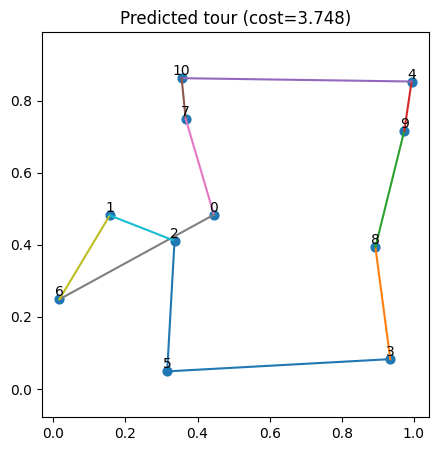

In [ ]:
def make_single_insert_batch(
    coords: np.ndarray,
    tour_partial: List[int],
    max_cities: int,
) -> Dict[str, torch.Tensor]:
    n_nodes = coords.shape[0]
    coords_pad = np.zeros((max_cities, 2), dtype=np.float32)
    coords_pad[:n_nodes] = coords

    node_valid_mask = np.zeros((max_cities,), dtype=np.bool_)
    node_valid_mask[:n_nodes] = True

    visited_mask = np.zeros((max_cities,), dtype=np.float32)
    for v in tour_partial:
        visited_mask[int(v)] = 1.0

    tour_pad = np.full((max_cities,), -1, dtype=np.int64)
    tour_pad[:len(tour_partial)] = np.array(tour_partial, dtype=np.int64)

    batch = {
        "coords": torch.from_numpy(coords_pad).unsqueeze(0),
        "node_valid_mask": torch.from_numpy(node_valid_mask).unsqueeze(0),
        "visited_mask": torch.from_numpy(visited_mask).unsqueeze(0),
        "tour_partial": torch.from_numpy(tour_pad).unsqueeze(0),
        "partial_length": torch.tensor([len(tour_partial)], dtype=torch.long),
        # dummy targets
        "target_city": torch.tensor([0], dtype=torch.long),
        "target_edge_index": torch.tensor([0], dtype=torch.long),
        "cost_before": torch.tensor([float("nan")]),
        "cost_after": torch.tensor([float("nan")]),
    }
    return batch


def make_single_two_opt_batch(
    coords: np.ndarray,
    tour_full: List[int],
    max_cities: int,
) -> Dict[str, torch.Tensor]:
    n_nodes = coords.shape[0]
    coords_pad = np.zeros((max_cities, 2), dtype=np.float32)
    coords_pad[:n_nodes] = coords

    node_valid_mask = np.zeros((max_cities,), dtype=np.bool_)
    node_valid_mask[:n_nodes] = True

    tour_pad = np.full((max_cities,), -1, dtype=np.int64)
    tour_pad[:n_nodes] = np.array(tour_full, dtype=np.int64)

    pairs = enumerate_two_opt_pairs(tour_full)
    num_slots = len(pairs) + 1  # + STOP
    pair_indices = np.full((num_slots, 2), -1, dtype=np.int64)
    if len(pairs) > 0:
        pair_indices[:len(pairs)] = np.array(pairs, dtype=np.int64)

    pair_mask = np.zeros((num_slots,), dtype=np.bool_)
    pair_mask[:num_slots] = True

    batch = {
        "coords": torch.from_numpy(coords_pad).unsqueeze(0),
        "node_valid_mask": torch.from_numpy(node_valid_mask).unsqueeze(0),
        "tour_full": torch.from_numpy(tour_pad).unsqueeze(0),
        "n_nodes": torch.tensor([n_nodes], dtype=torch.long),
        "pair_indices": torch.from_numpy(pair_indices).unsqueeze(0),
        "pair_mask": torch.from_numpy(pair_mask).unsqueeze(0),
        # dummy target
        "target_pair_index": torch.tensor([0], dtype=torch.long),
        "cost_before": torch.tensor([float("nan")]),
        "cost_after": torch.tensor([float("nan")]),
    }
    return batch


def solve_tsp_with_policies(
    coords: np.ndarray,
    insert_policy: InsertPolicy,
    two_opt_policy: TwoOptPolicy,
    max_cities: int,
    outer_steps: int,
    start_size: int = 3,
    max_two_opt_steps: int = 50,
) -> List[int]:
    n_nodes = coords.shape[0]
    assert n_nodes <= max_cities

    # Start partial tour with first start_size nodes
    start_size = min(start_size, n_nodes)
    tour_partial = list(range(start_size))

    # Insert remaining nodes
    while len(tour_partial) < n_nodes:
        batch = make_single_insert_batch(coords, tour_partial, max_cities)
        pred_city, pred_edge = insert_policy.predict(batch, outer_steps=outer_steps)
        city = int(pred_city.item())
        edge = int(pred_edge.item())

        # If model outputs a visited city (should be rare), pick first unvisited as fallback
        if city in set(tour_partial):
            for candidate in range(n_nodes):
                if candidate not in set(tour_partial):
                    city = candidate
                    break

        tour_partial = apply_insert_action(tour_partial, city=city, edge_index=edge)

    tour_full = tour_partial

    # Improve with 2-opt until STOP
    for _ in range(max_two_opt_steps):
        batch = make_single_two_opt_batch(coords, tour_full, max_cities)
        pred_index = int(two_opt_policy.predict(batch, outer_steps=outer_steps).item())

        pairs = enumerate_two_opt_pairs(tour_full)
        stop_index = len(pairs)
        if pred_index == stop_index:
            break

        i, j = pairs[pred_index]
        tour_full = apply_two_opt_action(tour_full, i=i, j=j)

    return tour_full


# Demo: picking one random instance from the two_opt_val split for a full tour baseline
random_index = np.random.randint(0, len(two_opt_val))
demo_item = two_opt_val[random_index]
coords_demo = demo_item["coords"]
n_nodes_demo = coords_demo.shape[0]

# Create a naive baseline tour (0 to n-1)
baseline_tour = list(range(n_nodes_demo))

pred_tour = solve_tsp_with_policies(
    coords=coords_demo,
    insert_policy=insert_policy,
    two_opt_policy=two_opt_policy,
    max_cities=MAX_CITIES,
    outer_steps=OUTER_STEPS,
    start_size=3,
    max_two_opt_steps=50,
)

print("n_nodes:", n_nodes_demo)
print("Baseline tour:", baseline_tour)
print("Predicted tour:", pred_tour)

baseline_cost = tour_cost(coords_demo, baseline_tour)
pred_cost = tour_cost(coords_demo, pred_tour)
print("Baseline cost:", baseline_cost)
print("Predicted cost:", pred_cost)

# Plot
plt.figure(figsize=(5,5))
plt.scatter(coords_demo[:,0], coords_demo[:,1], s=40)
for city_index, (x, y) in enumerate(coords_demo):
    plt.text(x, y, str(city_index), ha="center", va="bottom")

for k in range(len(pred_tour)):
    a = pred_tour[k]
    b = pred_tour[(k + 1) % len(pred_tour)]
    plt.plot([coords_demo[a,0], coords_demo[b,0]], [coords_demo[a,1], coords_demo[b,1]])

plt.title(f"Predicted tour (cost={pred_cost:.3f})")
plt.axis("equal")
plt.show()


# results!!!

In [ ]:
import platform
import time
from pathlib import Path
import pandas as pandas

# Reproducibility: you already have set_seed(); keep using it
EXPERIMENT_NAME = "trm_tsp_paper_run_v1"
ARTIFACTS_DIR = Path("paper_artifacts") / EXPERIMENT_NAME
FIGURES_DIR = ARTIFACTS_DIR / "figures"
CHECKPOINTS_DIR = ARTIFACTS_DIR / "checkpoints"
TABLES_DIR = ARTIFACTS_DIR / "tables"

for directory_path in [ARTIFACTS_DIR, FIGURES_DIR, CHECKPOINTS_DIR, TABLES_DIR]:
    directory_path.mkdir(parents=True, exist_ok=True)

def get_git_commit_hash_or_none() -> str | None:
    try:
        import subprocess
        commit_hash = subprocess.check_output(["git", "rev-parse", "HEAD"]).decode("utf-8").strip()
        return commit_hash
    except Exception:
        return None

experiment_metadata = {
    "experiment_name": EXPERIMENT_NAME,
    "timestamp_unix": int(time.time()),
    "python_version": platform.python_version(),
    "pytorch_version": torch.__version__,
    "numpy_version": np.__version__,
    "device": str(device),
    "git_commit": get_git_commit_hash_or_none(),
    "hyperparameters": {
        "MAX_CITIES": MAX_CITIES,
        "D_MODEL": D_MODEL,
        "N_HEADS": N_HEADS,
        "N_LAYERS": N_LAYERS,
        "INNER_Z_UPDATES": INNER_Z_UPDATES,
        "DEEP_RECURSIONS": DEEP_RECURSIONS,
        "K_LAST_OPS": K_LAST_OPS,
        "OUTER_STEPS": OUTER_STEPS,
        "OUTER_GRAD_STEPS_INSERT": OUTER_GRAD_STEPS_INSERT,
        "OUTER_GRAD_STEPS_TWO_OPT": OUTER_GRAD_STEPS_TWO_OPT,
        "LEARNING_RATE": LEARNING_RATE,
        "WEIGHT_DECAY": WEIGHT_DECAY,
        "EPOCHS_INSERT": EPOCHS_INSERT,
        "EPOCHS_TWO_OPT": EPOCHS_TWO_OPT,
        "BATCH_SIZE_INSERT": BATCH_SIZE,
        "BATCH_SIZE_TWO_OPT": BATCH_SIZE_TWO_OPT,
        "USE_AMP": USE_AMP,
    },
}

with open(ARTIFACTS_DIR / "metadata.json", "w") as file_handle:
    json.dump(experiment_metadata, file_handle, indent=2)

print("wrote metadata to:", ARTIFACTS_DIR / "metadata.json")


Wrote metadata to: paper_artifacts/trm_tsp_paper_run_v1/metadata.json


In [ ]:
from copy import deepcopy

def build_fresh_insert_policy_and_optimizer() -> tuple[InsertPolicy, torch.optim.Optimizer]:
    backbone_insert_local = TRMBackbone(
        max_cities=MAX_CITIES,
        d_model=D_MODEL,
        n_layers=N_LAYERS,
        n_heads=N_HEADS,
        inner_z_updates=INNER_Z_UPDATES,
        deep_recursions=DEEP_RECURSIONS,
        k_last_ops=K_LAST_OPS,
    ).to(device)

    insert_policy_local = InsertPolicy(
        max_cities=MAX_CITIES,
        d_model=D_MODEL,
        backbone=backbone_insert_local,
    ).to(device)

    optimizer_insert_local = torch.optim.AdamW(
        insert_policy_local.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        betas=(0.9, 0.95),
    )
    return insert_policy_local, optimizer_insert_local


def build_fresh_two_opt_policy_and_optimizer() -> tuple[TwoOptPolicy, torch.optim.Optimizer]:
    backbone_two_opt_local = TRMBackbone(
        max_cities=MAX_CITIES,
        d_model=D_MODEL,
        n_layers=N_LAYERS,
        n_heads=N_HEADS,
        inner_z_updates=INNER_Z_UPDATES,
        deep_recursions=DEEP_RECURSIONS,
        k_last_ops=K_LAST_OPS,
    ).to(device)

    two_opt_policy_local = TwoOptPolicy(
        max_cities=MAX_CITIES,
        d_model=D_MODEL,
        backbone=backbone_two_opt_local,
    ).to(device)

    optimizer_two_opt_local = torch.optim.AdamW(
        two_opt_policy_local.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        betas=(0.9, 0.95),
    )
    return two_opt_policy_local, optimizer_two_opt_local


def train_insert_with_logging_and_checkpoints(
    insert_policy_model: InsertPolicy,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    outer_steps: int,
    outer_grad_steps: int,
) -> pandas.DataFrame:
    best_val_acc_both = -1.0
    best_checkpoint_path = CHECKPOINTS_DIR / "best_insert_policy.pt"
    history_rows: list[dict[str, float]] = []

    for epoch_index in range(1, num_epochs + 1):
        train_metrics = train_one_epoch_insert(
            policy=insert_policy_model,
            loader=insert_train_loader,
            optimizer=optimizer,
            grad_scaler=grad_scaler,
            epoch=epoch_index,
            outer_steps=outer_steps,
            outer_grad_steps=outer_grad_steps,
            use_amp=USE_AMP,
        )
        val_metrics = evaluate_insert(
            policy=insert_policy_model,
            loader=insert_val_loader,
            outer_steps=outer_steps,
        )

        row = {
            "epoch": epoch_index,
            "train_loss": float(train_metrics["loss"]),
            "train_loss_city": float(train_metrics["loss_city"]),
            "train_loss_edge": float(train_metrics["loss_edge"]),
            "val_acc_city": float(val_metrics["acc_city"]),
            "val_acc_edge": float(val_metrics["acc_edge"]),
            "val_acc_both": float(val_metrics["acc_both"]),
        }
        history_rows.append(row)

        if val_metrics["acc_both"] > best_val_acc_both:
            best_val_acc_both = float(val_metrics["acc_both"])
            torch.save(
                {
                    "epoch": epoch_index,
                    "state_dict": insert_policy_model.state_dict(),
                    "best_val_acc_both": best_val_acc_both,
                    "metadata": experiment_metadata,
                },
                best_checkpoint_path,
            )

        print(
            f"[Insert] Epoch {epoch_index:02d} | "
            f"TrainLoss {row['train_loss']:.4f} | "
            f"Val acc_city {row['val_acc_city']:.3f} "
            f"acc_edge {row['val_acc_edge']:.3f} "
            f"acc_both {row['val_acc_both']:.3f} | "
            f"Best acc_both {best_val_acc_both:.3f}"
        )

    history_table = pandas.DataFrame(history_rows)
    history_table.to_csv(TABLES_DIR / "insert_training_history.csv", index=False)

    # Load best checkpoint back into the model
    best_state = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
    insert_policy_model.load_state_dict(best_state["state_dict"])

    print("Saved:", best_checkpoint_path)
    print("Saved:", TABLES_DIR / "insert_training_history.csv")
    return history_table


def train_two_opt_with_logging_and_checkpoints(
    two_opt_policy_model: TwoOptPolicy,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    outer_steps: int,
    outer_grad_steps: int,
) -> pandas.DataFrame:
    best_val_acc_all = -1.0
    best_checkpoint_path = CHECKPOINTS_DIR / "best_two_opt_policy.pt"
    history_rows: list[dict[str, float]] = []

    for epoch_index in range(1, num_epochs + 1):
        train_metrics = train_one_epoch_two_opt(
            policy=two_opt_policy_model,
            loader=two_opt_train_loader,
            optimizer=optimizer,
            grad_scaler=grad_scaler,
            epoch=epoch_index,
            outer_steps=outer_steps,
            outer_grad_steps=outer_grad_steps,
            use_amp=USE_AMP,
        )
        val_metrics = evaluate_two_opt(
            policy=two_opt_policy_model,
            loader=two_opt_val_loader,
            outer_steps=outer_steps,
        )

        row = {
            "epoch": epoch_index,
            "train_loss": float(train_metrics["loss"]),
            "val_acc_all": float(val_metrics["acc_all"]),
            "val_acc_stop": float(val_metrics["acc_stop"]),
            "val_acc_nonstop": float(val_metrics["acc_nonstop"]),
        }
        history_rows.append(row)

        if val_metrics["acc_all"] > best_val_acc_all:
            best_val_acc_all = float(val_metrics["acc_all"])
            torch.save(
                {
                    "epoch": epoch_index,
                    "state_dict": two_opt_policy_model.state_dict(),
                    "best_val_acc_all": best_val_acc_all,
                    "metadata": experiment_metadata,
                },
                best_checkpoint_path,
            )

        print(
            f"[TwoOpt] Epoch {epoch_index:02d} | "
            f"TrainLoss {row['train_loss']:.4f} | "
            f"Val acc_all {row['val_acc_all']:.3f} "
            f"acc_stop {row['val_acc_stop']:.3f} "
            f"acc_nonstop {row['val_acc_nonstop']:.3f} | "
            f"Best acc_all {best_val_acc_all:.3f}"
        )

    history_table = pandas.DataFrame(history_rows)
    history_table.to_csv(TABLES_DIR / "two_opt_training_history.csv", index=False)

    # Load best checkpoint back into the model
    best_state = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
    two_opt_policy_model.load_state_dict(best_state["state_dict"])

    print("Saved:", best_checkpoint_path)
    print("Saved:", TABLES_DIR / "two_opt_training_history.csv")
    return history_table


# rebuild and retrain from scratch for a clean run
RETRAIN_FROM_SCRATCH = True

if RETRAIN_FROM_SCRATCH:
    set_seed(123)
    if device.type == "cuda":
        torch.cuda.empty_cache()

    insert_policy, optimizer_insert = build_fresh_insert_policy_and_optimizer()
    two_opt_policy, optimizer_two_opt = build_fresh_two_opt_policy_and_optimizer()

    print("Insert policy params (M):", sum(p.numel() for p in insert_policy.parameters()) / 1e6)
    print("Two-opt policy params (M):", sum(p.numel() for p in two_opt_policy.parameters()) / 1e6)

    insert_history_table = train_insert_with_logging_and_checkpoints(
        insert_policy_model=insert_policy,
        optimizer=optimizer_insert,
        num_epochs=EPOCHS_INSERT,
        outer_steps=OUTER_STEPS,
        outer_grad_steps=OUTER_GRAD_STEPS_INSERT,
    )

    two_opt_history_table = train_two_opt_with_logging_and_checkpoints(
        two_opt_policy_model=two_opt_policy,
        optimizer=optimizer_two_opt,
        num_epochs=EPOCHS_TWO_OPT,
        outer_steps=OUTER_STEPS,
        outer_grad_steps=OUTER_GRAD_STEPS_TWO_OPT,
    )
else:
    # Load from disk if you already trained
    insert_checkpoint = torch.load(CHECKPOINTS_DIR / "best_insert_policy.pt", map_location=device, weights_only=False)
    two_opt_checkpoint = torch.load(CHECKPOINTS_DIR / "best_two_opt_policy.pt", map_location=device, weights_only=False)

    insert_policy, _ = build_fresh_insert_policy_and_optimizer()
    two_opt_policy, _ = build_fresh_two_opt_policy_and_optimizer()
    insert_policy.load_state_dict(insert_checkpoint["state_dict"])
    two_opt_policy.load_state_dict(two_opt_checkpoint["state_dict"])

    insert_history_table = pandas.read_csv(TABLES_DIR / "insert_training_history.csv")
    two_opt_history_table = pandas.read_csv(TABLES_DIR / "two_opt_training_history.csv")

print("Training ready, Artifacts at:", ARTIFACTS_DIR)


Insert policy params (M): 1.333056
Two-opt policy params (M): 1.480896
[Insert] Epoch 01 | TrainLoss 5.4497 | Val acc_city 0.291 acc_edge 0.391 acc_both 0.083 | Best acc_both 0.083
[Insert] Epoch 02 | TrainLoss 5.1163 | Val acc_city 0.305 acc_edge 0.434 acc_both 0.116 | Best acc_both 0.116
[Insert] Epoch 03 | TrainLoss 4.9770 | Val acc_city 0.318 acc_edge 0.424 acc_both 0.152 | Best acc_both 0.152
[Insert] Epoch 04 | TrainLoss 4.9167 | Val acc_city 0.325 acc_edge 0.414 acc_both 0.156 | Best acc_both 0.156
[Insert] Epoch 05 | TrainLoss 4.8640 | Val acc_city 0.318 acc_edge 0.444 acc_both 0.146 | Best acc_both 0.156
[Insert] Epoch 06 | TrainLoss 4.8599 | Val acc_city 0.341 acc_edge 0.454 acc_both 0.185 | Best acc_both 0.185
[Insert] Epoch 07 | TrainLoss 4.8145 | Val acc_city 0.341 acc_edge 0.427 acc_both 0.175 | Best acc_both 0.185
[Insert] Epoch 08 | TrainLoss 4.7996 | Val acc_city 0.334 acc_edge 0.421 acc_both 0.162 | Best acc_both 0.185
[Insert] Epoch 09 | TrainLoss 4.7983 | Val acc_ci

Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig1_insert_learning_curve.png
Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig1_insert_learning_curve.pdf


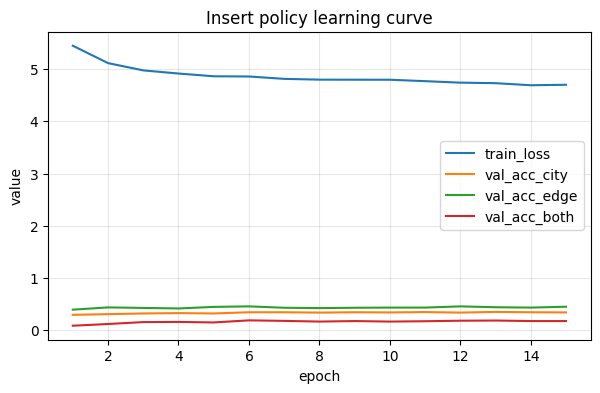

Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig2_two_opt_learning_curve.png
Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig2_two_opt_learning_curve.pdf


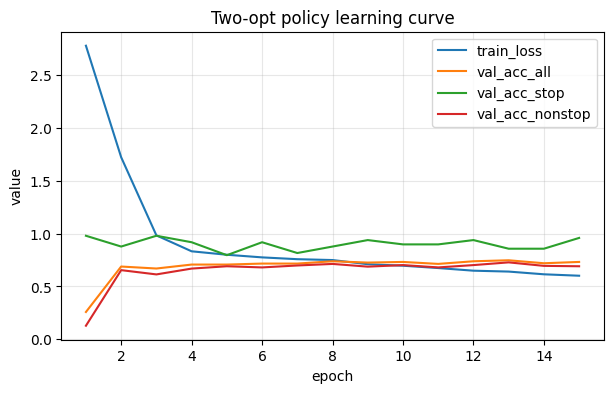

In [50]:
import matplotlib.pyplot as plt

def save_figure_both_png_and_pdf(figure_path_without_suffix: Path) -> None:
    png_path = figure_path_without_suffix.with_suffix(".png")
    pdf_path = figure_path_without_suffix.with_suffix(".pdf")
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    print("Saved:", png_path)
    print("Saved:", pdf_path)

# Figure 1: Insert learning curve
plt.figure(figsize=(7, 4))
plt.plot(insert_history_table["epoch"], insert_history_table["train_loss"], label="train_loss")
plt.plot(insert_history_table["epoch"], insert_history_table["val_acc_city"], label="val_acc_city")
plt.plot(insert_history_table["epoch"], insert_history_table["val_acc_edge"], label="val_acc_edge")
plt.plot(insert_history_table["epoch"], insert_history_table["val_acc_both"], label="val_acc_both")
plt.xlabel("epoch")
plt.ylabel("value")
plt.title("Insert policy learning curve")
plt.grid(True, alpha=0.3)
plt.legend()
save_figure_both_png_and_pdf(FIGURES_DIR / "fig1_insert_learning_curve")
plt.show()

# Figure 2: Two-opt learning curve
plt.figure(figsize=(7, 4))
plt.plot(two_opt_history_table["epoch"], two_opt_history_table["train_loss"], label="train_loss")
plt.plot(two_opt_history_table["epoch"], two_opt_history_table["val_acc_all"], label="val_acc_all")
plt.plot(two_opt_history_table["epoch"], two_opt_history_table["val_acc_stop"], label="val_acc_stop")
plt.plot(two_opt_history_table["epoch"], two_opt_history_table["val_acc_nonstop"], label="val_acc_nonstop")
plt.xlabel("epoch")
plt.ylabel("value")
plt.title("Two-opt policy learning curve")
plt.grid(True, alpha=0.3)
plt.legend()
save_figure_both_png_and_pdf(FIGURES_DIR / "fig2_two_opt_learning_curve")
plt.show()


In [ ]:
def compute_tour_cost_from_distance(distance_matrix: np.ndarray, tour: list[int]) -> float:
    return float(tour_length(distance_matrix, tour))

def nearest_neighbor_tour(distance_matrix: np.ndarray, start_city: int = 0) -> list[int]:
    num_cities = int(distance_matrix.shape[0])
    unvisited = set(range(num_cities))
    tour = [int(start_city)]
    unvisited.remove(int(start_city))

    current_city = int(start_city)
    while unvisited:
        next_city = min(unvisited, key=lambda city_index: float(distance_matrix[current_city, city_index]))
        tour.append(int(next_city))
        unvisited.remove(int(next_city))
        current_city = int(next_city)

    return tour

def random_tour(num_cities: int, random_state: np.random.RandomState) -> list[int]:
    return random_state.permutation(num_cities).astype(int).tolist()

def two_opt_best_improvement(
    initial_tour: list[int],
    distance_matrix: np.ndarray,
    max_iterations: int = 200,
) -> tuple[list[int], int]:
    """
    Classic 2-opt with best-improvement. Returns (tour, num_applied_moves)
    Uses the enumerate_two_opt_pairs and apply_two_opt_action for consistency
    """
    tour = list(initial_tour)
    num_cities = len(tour)
    applied_moves = 0

    for _ in range(max_iterations):
        best_delta = 0.0
        best_pair = None

        candidate_pairs = enumerate_two_opt_pairs(tour)
        for i_index, j_index in candidate_pairs:
            city_a = tour[i_index - 1]
            city_b = tour[i_index]
            city_c = tour[j_index]
            city_d = tour[(j_index + 1) % num_cities]

            old_cost = float(distance_matrix[city_a, city_b] + distance_matrix[city_c, city_d])
            new_cost = float(distance_matrix[city_a, city_c] + distance_matrix[city_b, city_d])
            delta = new_cost - old_cost  # negative means improvement

            if delta < best_delta:
                best_delta = delta
                best_pair = (i_index, j_index)

        if best_pair is None:
            break

        i_index, j_index = best_pair
        tour = apply_two_opt_action(tour, i=i_index, j=j_index)
        applied_moves += 1

    return tour, applied_moves

def held_karp_optimal_cost(distance_matrix: np.ndarray) -> float:
    """
    Exact TSP optimum (cycle) via Held-Karp dynamic programming
    Fixes start city at 0. Complexity O(n^2 * 2^n)
    Suitable for n <= 12 (your MAX_CITIES)
    """
    num_cities = int(distance_matrix.shape[0])
    if num_cities <= 1:
        return 0.0
    if num_cities == 2:
        return float(distance_matrix[0, 1] + distance_matrix[1, 0])

    # We build subsets over cities 1 to (n-1)
    num_subset_bits = num_cities - 1
    num_subsets = 1 << num_subset_bits

    dynamic_programming_table = np.full((num_subsets, num_cities), np.inf, dtype=np.float64)

    # Base: only one city j in subset
    for last_city in range(1, num_cities):
        subset_mask = 1 << (last_city - 1)
        dynamic_programming_table[subset_mask, last_city] = float(distance_matrix[0, last_city])

    # Fill
    for subset_mask in range(num_subsets):
        for last_city in range(1, num_cities):
            if (subset_mask & (1 << (last_city - 1))) == 0:
                continue
            prev_mask = subset_mask ^ (1 << (last_city - 1))
            if prev_mask == 0:
                continue

            best_value = np.inf
            for prev_city in range(1, num_cities):
                if (prev_mask & (1 << (prev_city - 1))) == 0:
                    continue
                candidate = dynamic_programming_table[prev_mask, prev_city] + float(distance_matrix[prev_city, last_city])
                if candidate < best_value:
                    best_value = candidate

            dynamic_programming_table[subset_mask, last_city] = best_value

    full_mask = num_subsets - 1
    best_tour_cost = np.inf
    for last_city in range(1, num_cities):
        candidate = dynamic_programming_table[full_mask, last_city] + float(distance_matrix[last_city, 0])
        if candidate < best_tour_cost:
            best_tour_cost = candidate

    return float(best_tour_cost)


In [52]:
def synchronize_if_cuda() -> None:
    if device.type == "cuda":
        torch.cuda.synchronize()

@torch.no_grad()
def construct_tour_with_insert_policy_with_trace(
    coords: np.ndarray,
    insert_policy_model: InsertPolicy,
    max_cities: int,
    outer_steps: int,
    start_size: int = 3,
) -> tuple[list[int], dict[str, float]]:
    num_cities = int(coords.shape[0])
    start_size = int(min(start_size, num_cities))

    tour_partial = list(range(start_size))
    fallback_count = 0
    insert_steps = 0

    while len(tour_partial) < num_cities:
        batch = make_single_insert_batch(coords, tour_partial, max_cities=max_cities)
        predicted_city_tensor, predicted_edge_tensor = insert_policy_model.predict(batch, outer_steps=outer_steps)
        predicted_city = int(predicted_city_tensor.item())
        predicted_edge = int(predicted_edge_tensor.item())

        if predicted_city in set(tour_partial):
            fallback_count += 1
            for candidate_city in range(num_cities):
                if candidate_city not in set(tour_partial):
                    predicted_city = candidate_city
                    break

        tour_partial = apply_insert_action(tour_partial, city=predicted_city, edge_index=predicted_edge)
        insert_steps += 1

    trace = {
        "insert_fallback_count": float(fallback_count),
        "insert_steps": float(insert_steps),
    }
    return tour_partial, trace

@torch.no_grad()
def improve_tour_with_two_opt_policy_with_trace(
    coords: np.ndarray,
    initial_tour: list[int],
    two_opt_policy_model: TwoOptPolicy,
    max_cities: int,
    outer_steps: int,
    max_two_opt_steps: int = 50,
) -> tuple[list[int], dict[str, float]]:
    tour_full = list(initial_tour)
    applied_steps = 0
    stopped_early = 0

    for _ in range(int(max_two_opt_steps)):
        batch = make_single_two_opt_batch(coords, tour_full, max_cities=max_cities)
        predicted_index = int(two_opt_policy_model.predict(batch, outer_steps=outer_steps).item())

        pairs = enumerate_two_opt_pairs(tour_full)
        stop_index = len(pairs)

        if predicted_index == stop_index:
            stopped_early = 1
            break

        i_index, j_index = pairs[predicted_index]
        tour_full = apply_two_opt_action(tour_full, i=i_index, j=j_index)
        applied_steps += 1

    trace = {
        "two_opt_steps_applied": float(applied_steps),
        "two_opt_stopped": float(stopped_early),
    }
    return tour_full, trace

@torch.no_grad()
def solve_tsp_with_policies_with_trace(
    coords: np.ndarray,
    insert_policy_model: InsertPolicy,
    two_opt_policy_model: TwoOptPolicy,
    max_cities: int,
    outer_steps: int,
    start_size: int = 3,
    max_two_opt_steps: int = 50,
) -> tuple[list[int], dict[str, float]]:
    synchronize_if_cuda()
    start_time = time.perf_counter()

    inserted_tour, insert_trace = construct_tour_with_insert_policy_with_trace(
        coords=coords,
        insert_policy_model=insert_policy_model,
        max_cities=max_cities,
        outer_steps=outer_steps,
        start_size=start_size,
    )

    improved_tour, two_opt_trace = improve_tour_with_two_opt_policy_with_trace(
        coords=coords,
        initial_tour=inserted_tour,
        two_opt_policy_model=two_opt_policy_model,
        max_cities=max_cities,
        outer_steps=outer_steps,
        max_two_opt_steps=max_two_opt_steps,
    )

    synchronize_if_cuda()
    elapsed_seconds = time.perf_counter() - start_time

    trace = {}
    trace.update(insert_trace)
    trace.update(two_opt_trace)
    trace["solve_time_ms"] = float(elapsed_seconds * 1000.0)
    return improved_tour, trace


In [ ]:
def generate_random_euclidean_tsp_instances(
    num_instances_per_num_cities: int,
    num_cities_values: list[int],
    seed: int,
) -> list[dict[str, object]]:
    random_state = np.random.RandomState(seed)
    instances: list[dict[str, object]] = []
    for num_cities in num_cities_values:
        for instance_index in range(num_instances_per_num_cities):
            coords = random_state.rand(num_cities, 2).astype(np.float32)
            instances.append(
                {
                    "instance_id": f"n{num_cities:02d}_{instance_index:04d}",
                    "num_cities": int(num_cities),
                    "coords": coords,
                }
            )
    return instances

def evaluate_all_methods_on_instances(
    instances: list[dict[str, object]],
    insert_policy_model: InsertPolicy,
    two_opt_policy_model: TwoOptPolicy,
    outer_steps: int,
    start_size: int = 3,
    max_two_opt_steps: int = 50,
    seed_for_random_baseline: int = 999,
) -> pandas.DataFrame:
    random_state = np.random.RandomState(seed_for_random_baseline)

    rows: list[dict[str, object]] = []

    for instance in instances:
        instance_id = str(instance["instance_id"])
        num_cities = int(instance["num_cities"])
        coords = np.array(instance["coords"], dtype=np.float32)

        distance_matrix = pairwise_euclidean(coords)

        optimal_cost = held_karp_optimal_cost(distance_matrix)

        # Baseline tours
        identity_tour = list(range(num_cities))
        identity_cost = compute_tour_cost_from_distance(distance_matrix, identity_tour)

        nn_tour = nearest_neighbor_tour(distance_matrix, start_city=0)
        nn_cost = compute_tour_cost_from_distance(distance_matrix, nn_tour)
        nn_2opt_tour, nn_2opt_moves = two_opt_best_improvement(nn_tour, distance_matrix)
        nn_2opt_cost = compute_tour_cost_from_distance(distance_matrix, nn_2opt_tour)

        random_baseline_tour = random_tour(num_cities, random_state)
        random_2opt_tour, random_2opt_moves = two_opt_best_improvement(random_baseline_tour, distance_matrix)
        random_2opt_cost = compute_tour_cost_from_distance(distance_matrix, random_2opt_tour)

        # TRM insert-only
        inserted_tour, insert_trace = construct_tour_with_insert_policy_with_trace(
            coords=coords,
            insert_policy_model=insert_policy_model,
            max_cities=MAX_CITIES,
            outer_steps=outer_steps,
            start_size=start_size,
        )
        trm_insert_only_cost = compute_tour_cost_from_distance(distance_matrix, inserted_tour)

        # TRM end-to-end
        trm_tour, trm_trace = solve_tsp_with_policies_with_trace(
            coords=coords,
            insert_policy_model=insert_policy_model,
            two_opt_policy_model=two_opt_policy_model,
            max_cities=MAX_CITIES,
            outer_steps=outer_steps,
            start_size=start_size,
            max_two_opt_steps=max_two_opt_steps,
        )
        trm_cost = compute_tour_cost_from_distance(distance_matrix, trm_tour)

        # Gaps (% over optimum)
        def gap_percent(cost: float) -> float:
            return float(100.0 * (cost / optimal_cost - 1.0))

        row = {
            "instance_id": instance_id,
            "num_cities": num_cities,
            "optimal_cost": float(optimal_cost),

            "identity_cost": float(identity_cost),
            "nn_cost": float(nn_cost),
            "nn_2opt_cost": float(nn_2opt_cost),
            "random_2opt_cost": float(random_2opt_cost),

            "trm_insert_only_cost": float(trm_insert_only_cost),
            "trm_cost": float(trm_cost),

            "gap_identity_percent": gap_percent(identity_cost),
            "gap_nn_percent": gap_percent(nn_cost),
            "gap_nn_2opt_percent": gap_percent(nn_2opt_cost),
            "gap_random_2opt_percent": gap_percent(random_2opt_cost),
            "gap_trm_insert_only_percent": gap_percent(trm_insert_only_cost),
            "gap_trm_percent": gap_percent(trm_cost),

            "nn_2opt_moves": int(nn_2opt_moves),
            "random_2opt_moves": int(random_2opt_moves),

            "trm_insert_fallback_count": int(insert_trace["insert_fallback_count"]),
            "trm_two_opt_steps_applied": int(trm_trace["two_opt_steps_applied"]),
            "trm_two_opt_stopped": int(trm_trace["two_opt_stopped"]),
            "trm_solve_time_ms": float(trm_trace["solve_time_ms"]),
        }
        rows.append(row)

    return pandas.DataFrame(rows)

# Benchmark setup
NUM_CITIES_VALUES = list(range(6, MAX_CITIES + 1))  # 6 to 12
NUM_INSTANCES_PER_NUM_CITIES = 60                   # adjust up/down for paper runs
EVAL_SEED = 2027

benchmark_instances = generate_random_euclidean_tsp_instances(
    num_instances_per_num_cities=NUM_INSTANCES_PER_NUM_CITIES,
    num_cities_values=NUM_CITIES_VALUES,
    seed=EVAL_SEED,
)

print("Benchmark instances:", len(benchmark_instances), "num_cities_values:", NUM_CITIES_VALUES)

results_table = evaluate_all_methods_on_instances(
    instances=benchmark_instances,
    insert_policy_model=insert_policy,
    two_opt_policy_model=two_opt_policy,
    outer_steps=OUTER_STEPS,
    start_size=3,
    max_two_opt_steps=50,
    seed_for_random_baseline=999,
)

results_csv_path = TABLES_DIR / "benchmark_results_per_instance.csv"
results_table.to_csv(results_csv_path, index=False)
print("Saved per-instance results to:", results_csv_path)

results_table.head()


Benchmark instances: 420 num_cities_values: [6, 7, 8, 9, 10, 11, 12]
Saved per-instance results to: paper_artifacts/trm_tsp_paper_run_v1/tables/benchmark_results_per_instance.csv


,instance_id,num_cities,optimal_cost,identity_cost,nn_cost,nn_2opt_cost,random_2opt_cost,trm_insert_only_cost,trm_cost,gap_identity_percent,...,gap_nn_2opt_percent,gap_random_2opt_percent,gap_trm_insert_only_percent,gap_trm_percent,nn_2opt_moves,random_2opt_moves,trm_insert_fallback_count,trm_two_opt_steps_applied,trm_two_opt_stopped,trm_solve_time_ms
0,n06_0000,6,2.265941,5.336450,4.410161,4.422046,4.582729,4.317209,4.317209,135.506970,...,95.152728,102.243960,90.526088,90.526088,1,1,0,0,1,559.127338
1,n06_0001,6,2.691907,6.493151,4.951718,4.951718,4.951718,4.951718,4.951718,141.210061,...,83.948338,83.948338,83.948338,83.948338,0,2,0,0,1,523.108309
2,n06_0002,6,2.777097,5.794335,5.547006,4.942992,5.224089,5.495416,5.495416,108.647191,...,77.991327,88.113280,97.883446,97.883446,1,2,0,0,1,523.576441
3,n06_0003,6,3.114929,6.966635,5.653820,5.653820,5.653820,5.653820,5.653820,123.653073,...,81.507165,81.507165,81.507165,81.507165,0,2,0,0,1,524.036538
4,n06_0004,6,2.626015,6.121288,4.906256,4.906256,4.906256,5.998585,5.998585,133.101762,...,86.832706,86.832706,128.429149,128.429149,0,1,0,0,1,519.338354


In [54]:
import math

def summarize_gap_column(gap_values: np.ndarray) -> dict[str, float]:
    gap_values = np.asarray(gap_values, dtype=np.float64)
    gap_values = gap_values[np.isfinite(gap_values)]
    count = int(gap_values.shape[0])
    mean = float(gap_values.mean()) if count > 0 else float("nan")
    std = float(gap_values.std(ddof=1)) if count > 1 else float("nan")
    standard_error = float(std / math.sqrt(count)) if count > 1 else float("nan")
    ci95 = float(1.96 * standard_error) if count > 1 else float("nan")
    return {"count": count, "mean": mean, "std": std, "ci95": ci95}

METHOD_GAP_COLUMNS = {
    "TRM (insert+2opt)": "gap_trm_percent",
    "TRM (insert only)": "gap_trm_insert_only_percent",
    "NN + 2opt": "gap_nn_2opt_percent",
    "NN": "gap_nn_percent",
    "Random + 2opt": "gap_random_2opt_percent",
    "Identity": "gap_identity_percent",
}

summary_rows: list[dict[str, object]] = []
for method_name, gap_column in METHOD_GAP_COLUMNS.items():
    stats = summarize_gap_column(results_table[gap_column].to_numpy())
    summary_rows.append(
        {
            "method": method_name,
            "count": stats["count"],
            "mean_gap_percent": stats["mean"],
            "std_gap_percent": stats["std"],
            "ci95_gap_percent": stats["ci95"],
        }
    )

summary_table = pandas.DataFrame(summary_rows).sort_values("mean_gap_percent")
summary_csv_path = TABLES_DIR / "benchmark_summary_by_method.csv"
summary_table.to_csv(summary_csv_path, index=False)
print("Saved summary to:", summary_csv_path)
summary_table


Saved summary to: paper_artifacts/trm_tsp_paper_run_v1/tables/benchmark_summary_by_method.csv


,method,count,mean_gap_percent,std_gap_percent,ci95_gap_percent
2,NN + 2opt,420,129.393480,25.802951,2.467748
3,NN,420,132.394308,27.440691,2.624378
0,TRM (insert+2opt),420,135.906766,31.263552,2.989990
4,Random + 2opt,420,135.921341,28.137080,2.690980
1,TRM (insert only),420,181.918550,57.668729,5.515334
5,Identity,420,260.738268,94.254561,9.014337


Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig3_gap_by_method.png
Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig3_gap_by_method.pdf


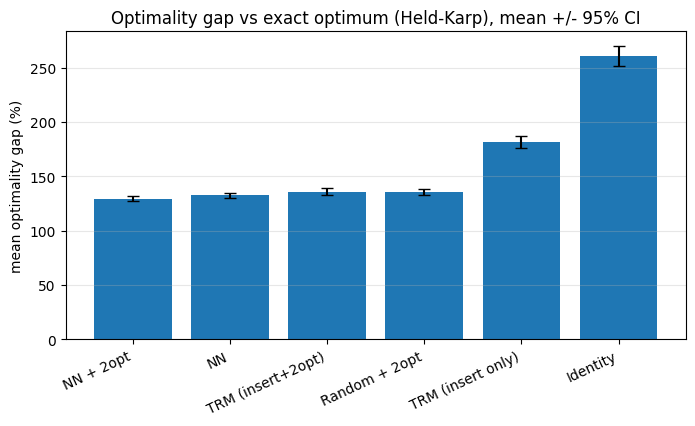

In [55]:
# Figure 3: Mean optimality gap by method (with 95% CI error bars)
plt.figure(figsize=(8, 4))
plot_methods = summary_table["method"].tolist()
plot_means = summary_table["mean_gap_percent"].to_numpy()
plot_ci95 = summary_table["ci95_gap_percent"].to_numpy()

x_positions = np.arange(len(plot_methods))
plt.bar(x_positions, plot_means, yerr=plot_ci95, capsize=4)
plt.xticks(x_positions, plot_methods, rotation=25, ha="right")
plt.ylabel("mean optimality gap (%)")
plt.title("Optimality gap vs exact optimum (Held-Karp), mean +/- 95% CI")
plt.grid(True, axis="y", alpha=0.3)

save_figure_both_png_and_pdf(FIGURES_DIR / "fig3_gap_by_method")
plt.show()


Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig4_gap_vs_num_cities.png
Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig4_gap_vs_num_cities.pdf


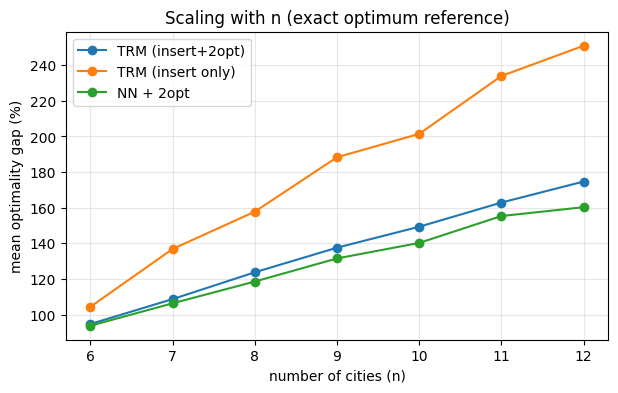

Saved: paper_artifacts/trm_tsp_paper_run_v1/tables/benchmark_summary_by_num_cities.csv


In [56]:
# Figure 4: Gap vs number of cities (scaling curve)
grouped_by_num_cities = results_table.groupby("num_cities", as_index=False).agg(
    mean_gap_trm_percent=("gap_trm_percent", "mean"),
    mean_gap_nn_2opt_percent=("gap_nn_2opt_percent", "mean"),
    mean_gap_trm_insert_only_percent=("gap_trm_insert_only_percent", "mean"),
)

plt.figure(figsize=(7, 4))
plt.plot(grouped_by_num_cities["num_cities"], grouped_by_num_cities["mean_gap_trm_percent"], marker="o", label="TRM (insert+2opt)")
plt.plot(grouped_by_num_cities["num_cities"], grouped_by_num_cities["mean_gap_trm_insert_only_percent"], marker="o", label="TRM (insert only)")
plt.plot(grouped_by_num_cities["num_cities"], grouped_by_num_cities["mean_gap_nn_2opt_percent"], marker="o", label="NN + 2opt")

plt.xlabel("number of cities (n)")
plt.ylabel("mean optimality gap (%)")
plt.title("Scaling with n (exact optimum reference)")
plt.grid(True, alpha=0.3)
plt.legend()

save_figure_both_png_and_pdf(FIGURES_DIR / "fig4_gap_vs_num_cities")
plt.show()

grouped_by_num_cities_csv_path = TABLES_DIR / "benchmark_summary_by_num_cities.csv"
grouped_by_num_cities.to_csv(grouped_by_num_cities_csv_path, index=False)
print("Saved:", grouped_by_num_cities_csv_path)


In [57]:
def evaluate_outer_steps_curve(
    instances: list[dict[str, object]],
    outer_steps_values: list[int],
    max_instances_total: int = 120,  # subset for speed; increase for paper final runs
    seed: int = 12345,
) -> pandas.DataFrame:
    random_state = np.random.RandomState(seed)
    if len(instances) > max_instances_total:
        chosen_indices = random_state.choice(len(instances), size=max_instances_total, replace=False)
        chosen_instances = [instances[int(index)] for index in chosen_indices]
    else:
        chosen_instances = instances

    rows: list[dict[str, object]] = []
    for outer_steps_value in outer_steps_values:
        gap_values: list[float] = []
        solve_time_values_ms: list[float] = []

        for instance in chosen_instances:
            coords = np.array(instance["coords"], dtype=np.float32)
            distance_matrix = pairwise_euclidean(coords)
            optimal_cost = held_karp_optimal_cost(distance_matrix)

            tour, trace = solve_tsp_with_policies_with_trace(
                coords=coords,
                insert_policy_model=insert_policy,
                two_opt_policy_model=two_opt_policy,
                max_cities=MAX_CITIES,
                outer_steps=int(outer_steps_value),
                start_size=3,
                max_two_opt_steps=50,
            )
            trm_cost = compute_tour_cost_from_distance(distance_matrix, tour)
            gap_percent = float(100.0 * (trm_cost / optimal_cost - 1.0))

            gap_values.append(gap_percent)
            solve_time_values_ms.append(float(trace["solve_time_ms"]))

        gap_stats = summarize_gap_column(np.array(gap_values, dtype=np.float64))
        time_stats = summarize_gap_column(np.array(solve_time_values_ms, dtype=np.float64))

        rows.append(
            {
                "outer_steps": int(outer_steps_value),
                "count": int(gap_stats["count"]),
                "mean_gap_percent": float(gap_stats["mean"]),
                "ci95_gap_percent": float(gap_stats["ci95"]),
                "mean_solve_time_ms": float(time_stats["mean"]),
                "ci95_solve_time_ms": float(time_stats["ci95"]),
            }
        )

    return pandas.DataFrame(rows).sort_values("outer_steps")

outer_steps_values = [1, 2, 3, 4, 5, OUTER_STEPS, OUTER_STEPS + 2]
outer_steps_values = sorted(set(int(v) for v in outer_steps_values if v >= 1))

outer_steps_curve_table = evaluate_outer_steps_curve(
    instances=benchmark_instances,
    outer_steps_values=outer_steps_values,
    max_instances_total=120,
)

outer_steps_curve_csv_path = TABLES_DIR / "outer_steps_curve.csv"
outer_steps_curve_table.to_csv(outer_steps_curve_csv_path, index=False)
print("Saved:", outer_steps_curve_csv_path)

outer_steps_curve_table


Saved: paper_artifacts/trm_tsp_paper_run_v1/tables/outer_steps_curve.csv


,outer_steps,count,mean_gap_percent,ci95_gap_percent,mean_solve_time_ms,ci95_solve_time_ms
0,1,120,134.206706,5.916352,235.005377,40.371181
1,2,120,134.817585,6.131558,569.278929,92.975528
2,3,120,134.916207,6.135133,870.524265,149.221778
3,4,120,134.916207,6.135133,1099.416122,183.461969
4,5,120,134.916207,6.135133,1291.349585,216.256862
5,6,120,134.916207,6.135133,1515.202744,256.362600
6,8,120,134.916207,6.135133,2065.232155,340.898015


Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig5_gap_vs_outer_steps.png
Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig5_gap_vs_outer_steps.pdf


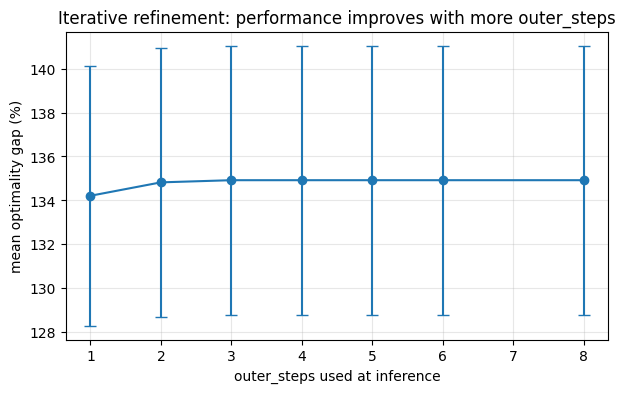

Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig5b_runtime_vs_outer_steps.png
Saved: paper_artifacts/trm_tsp_paper_run_v1/figures/fig5b_runtime_vs_outer_steps.pdf


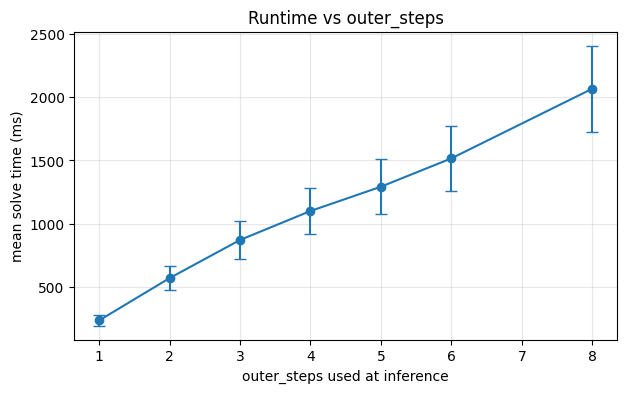

In [ ]:
# Figure 5: gap vs outer_steps (with 95% CI)
plt.figure(figsize=(7, 4))
plt.errorbar(
    outer_steps_curve_table["outer_steps"],
    outer_steps_curve_table["mean_gap_percent"],
    yerr=outer_steps_curve_table["ci95_gap_percent"],
    marker="o",
    capsize=4,
)
plt.xlabel("outer_steps used at inference")
plt.ylabel("mean optimality gap (%)")
plt.title("Iterative refinement: performance improves with more outer_steps")
plt.grid(True, alpha=0.3)

save_figure_both_png_and_pdf(FIGURES_DIR / "fig5_gap_vs_outer_steps")
plt.show()

# runtime curve
plt.figure(figsize=(7, 4))
plt.errorbar(
    outer_steps_curve_table["outer_steps"],
    outer_steps_curve_table["mean_solve_time_ms"],
    yerr=outer_steps_curve_table["ci95_solve_time_ms"],
    marker="o",
    capsize=4,
)
plt.xlabel("outer_steps used at inference")
plt.ylabel("mean solve time (ms)")
plt.title("Runtime vs outer_steps")
plt.grid(True, alpha=0.3)

save_figure_both_png_and_pdf(FIGURES_DIR / "fig5b_runtime_vs_outer_steps")
plt.show()


In [59]:
latex_method_table = summary_table.to_latex(
    index=False,
    float_format=lambda x: f"{x:.3f}",
)

latex_scaling_table = grouped_by_num_cities.to_latex(
    index=False,
    float_format=lambda x: f"{x:.3f}",
)

with open(TABLES_DIR / "latex_table_method_summary.tex", "w") as file_handle:
    file_handle.write(latex_method_table)

with open(TABLES_DIR / "latex_table_scaling_by_n.tex", "w") as file_handle:
    file_handle.write(latex_scaling_table)

print("Saved LaTeX tables to:")
print(" ", TABLES_DIR / "latex_table_method_summary.tex")
print(" ", TABLES_DIR / "latex_table_scaling_by_n.tex")

print("\nLaTeX preview (method summary):\n")
print(latex_method_table)


Saved LaTeX tables to:
  paper_artifacts/trm_tsp_paper_run_v1/tables/latex_table_method_summary.tex
  paper_artifacts/trm_tsp_paper_run_v1/tables/latex_table_scaling_by_n.tex

LaTeX preview (method summary):

\begin{tabular}{lrrrr}
\toprule
method & count & mean_gap_percent & std_gap_percent & ci95_gap_percent \\
\midrule
NN + 2opt & 420 & 129.393 & 25.803 & 2.468 \\
NN & 420 & 132.394 & 27.441 & 2.624 \\
TRM (insert+2opt) & 420 & 135.907 & 31.264 & 2.990 \\
Random + 2opt & 420 & 135.921 & 28.137 & 2.691 \\
TRM (insert only) & 420 & 181.919 & 57.669 & 5.515 \\
Identity & 420 & 260.738 & 94.255 & 9.014 \\
\bottomrule
\end{tabular}



# YIKES